In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".9"
os.environ["WANDB_NOTEBOOK_NAME"] = "exploration.ipynb"

from ml_collections import config_dict
import jax.random as random
import jax.numpy as jnp
from absl import logging

from src.utils.training import setup_model, get_dataset_splits, train_loop

# set save plot face color to be white
import matplotlib.pyplot as plt
plt.rcParams["savefig.facecolor"] = "white"

In [2]:
RUN_EXTRA = False

In [3]:
logging.set_verbosity(logging.INFO)

In [4]:
rng = random.PRNGKey(0)
data_rng, model_rng = random.split(rng)

In [5]:
def get_config(angle) -> config_dict.ConfigDict:
    config = config_dict.ConfigDict()

    # Dataset config
    config.dataset = 'MNIST'
    # config.data_dir = '~/data'
    config.shuffle_buffer_size = 50_000
    config.repeat_after_batch = True  # NOTE: ordering of PP and repeat is important!
    config.train_split = 'train[10000:]'
    config.pp_train = f'value_range(-1, 1)|random_rotate(-{angle}, {angle}, fill_value=-1)|keep(["image"])'
    config.val_split = 'train[:10000]'
    config.pp_eval = f'value_range(-1, 1)|random_rotate(-{angle}, {angle}, fill_value=-1)|keep(["image", "label"])'

    # Model config
    config.model_name = 'VAE'
    config.model = config_dict.ConfigDict()
    # config.model.bounds = (0.25, 0.25, jnp.pi, 0.25, 0.25, jnp.pi)
    # config.model.offset = (0., 0., 0., 0., 0., 0.)
    config.model.latent_dim = 128
    ## q(Z|X̂) config
    config.model.Z_given_X = config_dict.ConfigDict()
    config.model.Z_given_X.conv_dims = [64, 128, 256]
    config.model.Z_given_X.dense_dims = [256]
    ## p(X̂|Z) config
    config.model.X_given_Z = config_dict.ConfigDict()
    config.model.X_given_Z.conv_dims = [256, 128, 64]
    config.model.X_given_Z.dense_dims = [256]
    # p(η|Xhat) config
    # config.model.Η_given_Xhat = config_dict.ConfigDict()
    # config.model.Η_given_Xhat.num_layers = 1
    # config.model.Η_given_Xhat.num_bins = 5
    # config.model.Η_given_Xhat.base = config_dict.ConfigDict()
    # config.model.Η_given_Xhat.base.dense_dims = [64, 32, 16]
    # config.model.Η_given_Xhat.base.conv_dims = []
    # config.model.Η_given_Xhat.base.dropout_rate = 0.
    # config.model.Η_given_Xhat.conditioner = config_dict.ConfigDict()
    # config.model.Η_given_Xhat.conditioner.hidden_dims = [256, 128]
    # config.model.Η_given_Xhat.conditioner.dropout_rate = 0.
    # config.model.Η_given_Xhat.trunk = config_dict.ConfigDict()
    # config.model.Η_given_Xhat.trunk.dense_dims = [256]
    # config.model.Η_given_Xhat.trunk.conv_dims = [32, 64, 128]
    # config.model.Η_given_Xhat.trunk.dropout_rate = 0.
    # # p(η|X) config
    # config.model.Η_given_X = config.model.Η_given_Xhat
    # TODO: raise error if config is not the same for both?

    # Training config
    config.total_steps = 5001
    config.eval_every = 500
    config.batch_size = 512

    ## Optimizer config
    config.optim_name = 'adamw'
    config.learning_rate = 1e-4
    config.optim = config_dict.ConfigDict()
    config.optim.weight_decay = 1e-4

    ## LR config
    config.lr_schedule_name = 'warmup_cosine_decay_schedule'
    config.lr_schedule = config_dict.ConfigDict()
    config.lr_schedule.peak_value = 10 * config.learning_rate
    config.lr_schedule.end_value = 1 * config.learning_rate
    config.lr_schedule.decay_steps = config.total_steps
    config.lr_schedule.warmup_steps = config.total_steps // 10

    ## α config
    # config.α = 0.5
    # config.α_schedule_name = "cosine_decay_schedule"
    # config.α_schedule = config_dict.ConfigDict()
    # α_end_value = 1
    # config.α_schedule.alpha = α_end_value / config.α
    # config.α_schedule.decay_steps = config.total_steps // 10 * 9
    config.α = 1

    ## β config
    config.β = 10
    config.β_schedule_name = "cosine_decay_schedule"
    config.β_schedule = config_dict.ConfigDict()
    β_end_value = 1
    config.β_schedule.alpha = β_end_value / config.β
    config.β_schedule.decay_steps = config.total_steps
    # config.β = 1

    ## γ config
    # config.γ = 10
    # config.γ_schedule_name = "cosine_decay_schedule"
    # config.γ_schedule = config_dict.ConfigDict()
    # γ_end_value = 1
    # config.γ_schedule.alpha = γ_end_value / config.γ
    # config.γ_schedule.decay_steps = config.total_steps
    config.γ = 1

    # MLL config
    # config.estimate_mll = True
    # config.mll = config_dict.ConfigDict()
    # config.mll.num_chains = 10
    # config.mll.num_steps = 1000
    # config.mll.step_size = 1e-1
    # config.mll.num_leapfrog_steps = 2

    return config

config = get_config(0)

In [6]:
train_ds, val_ds, _ = get_dataset_splits(config, data_rng, config.batch_size, config.batch_size)

INFO:absl:Initializing train dataset...
INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=0.0, θ_max=0.0, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image']):
{'image': 'float32[28, 28, 1]'}
INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]'}
INFO:absl:Initializing val dataset...
INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.mo

In [7]:
model, state = setup_model(config, model_rng, train_ds)

INFO:absl:Initializing model...
INFO:absl:config.model_name = VAE
INFO:absl:config.model = X_given_Z:
  conv_dims:
  - 256
  - 128
  - 64
  dense_dims:
  - 256
Z_given_X:
  conv_dims:
  - 64
  - 128
  - 256
  dense_dims:
  - 256
latent_dim: 128

INFO:absl:input_size = (28, 28, 1)
INFO:absl:Initializing model...
INFO:absl:
+-----------------------------------+------------------+------------+-----------+----------+
| Name                              | Shape            | Size       | Mean      | Std      |
+-----------------------------------+------------------+------------+-----------+----------+
| params/p_X_given_Z/conv_1/bias    | (256,)           | 256        | 0.0       | 0.0      |
| params/p_X_given_Z/conv_1/kernel  | (3, 3, 1, 256)   | 2,304      | 0.00982   | 0.333    |
| params/p_X_given_Z/conv_2/bias    | (128,)           | 128        | 0.0       | 0.0      |
| params/p_X_given_Z/conv_2/kernel  | (3, 3, 256, 128) | 294,912    | 1.1e-05   | 0.0208   |
| params/p_X_given_Z/conv

wandb: Currently logged in as: jamesallingham (invariance-learners). Use `wandb login --relogin` to force relogin


INFO:absl:Setting up datasets...
INFO:absl:Global batch size 512 on 1 hosts results in 512 local batch size. With 1 devices per host (1 devices total), that's a 512 per-device batch size.
INFO:absl:Initializing train dataset...
INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Featur

  0%|          | 0/5001 [00:00<?, ?it/s]

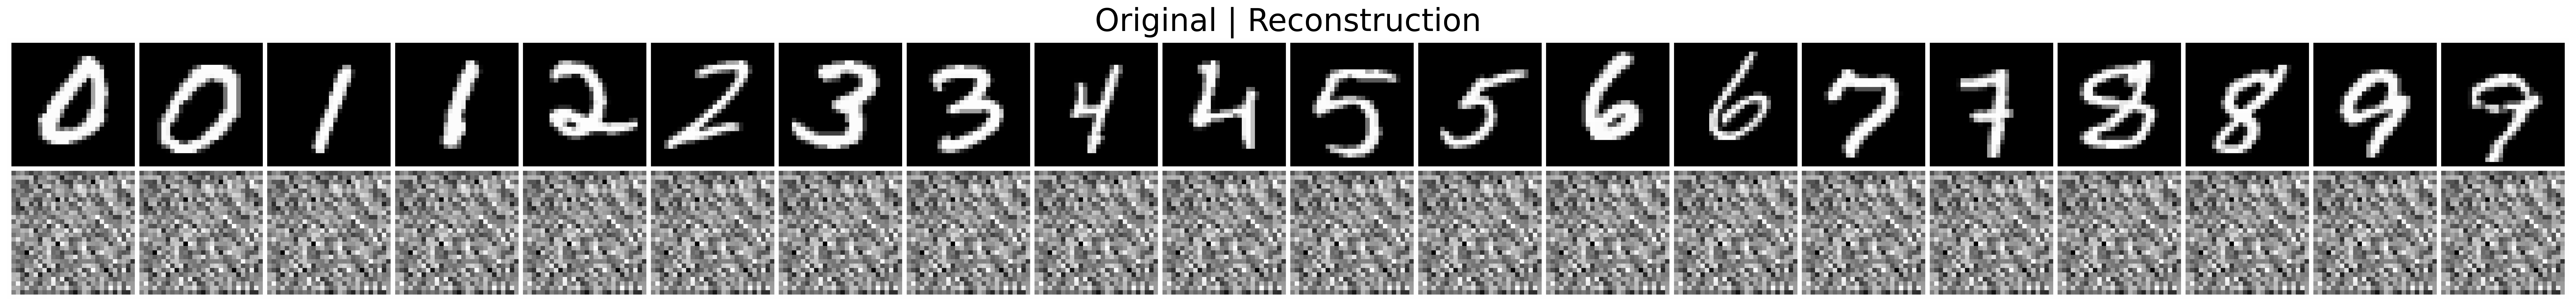

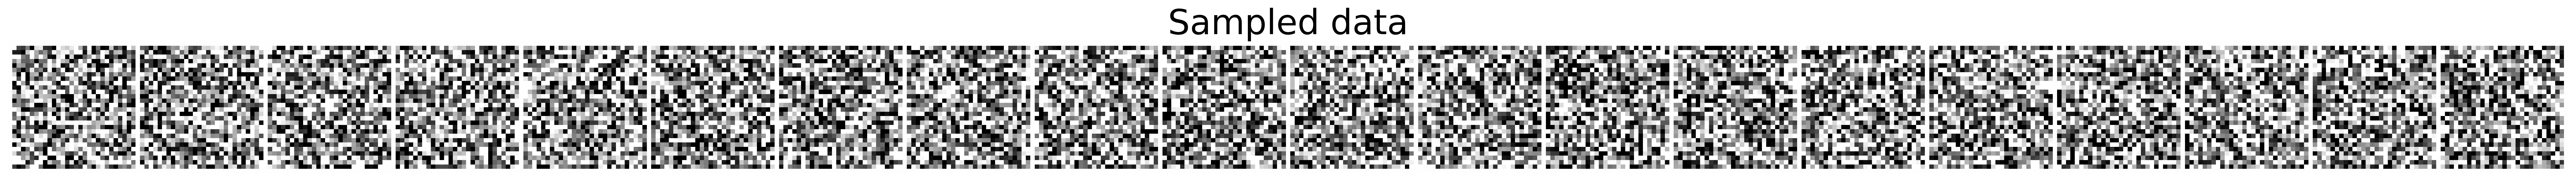

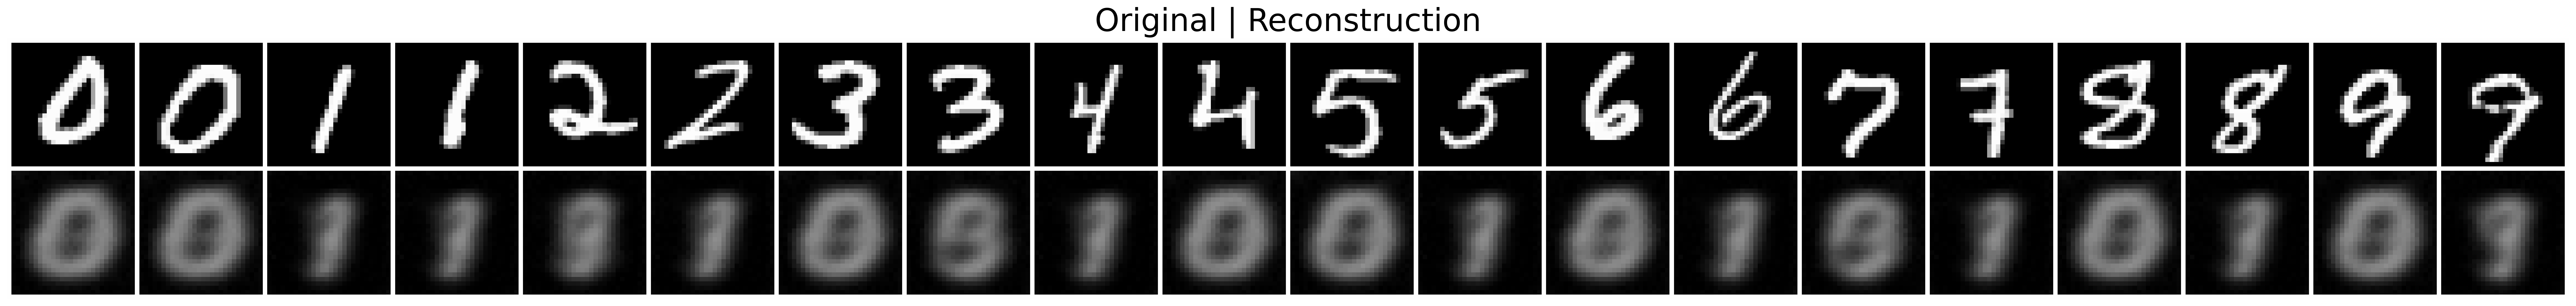

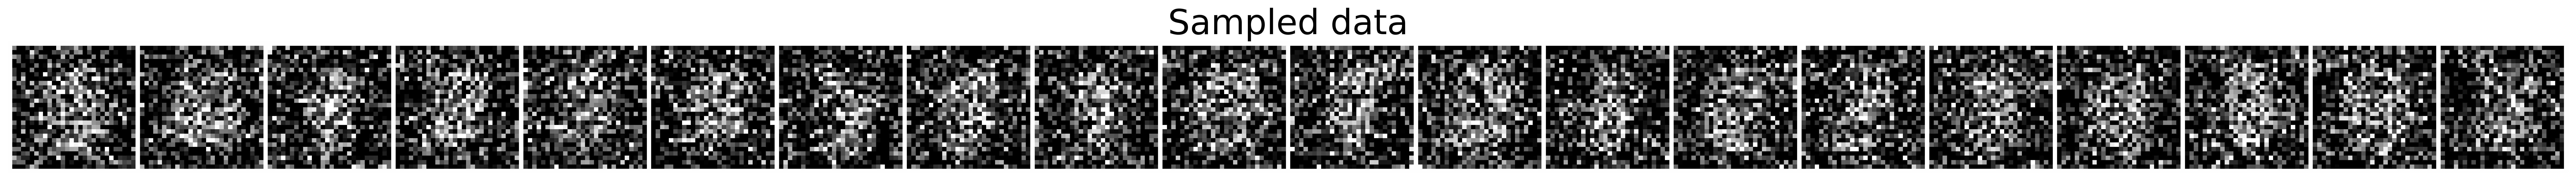

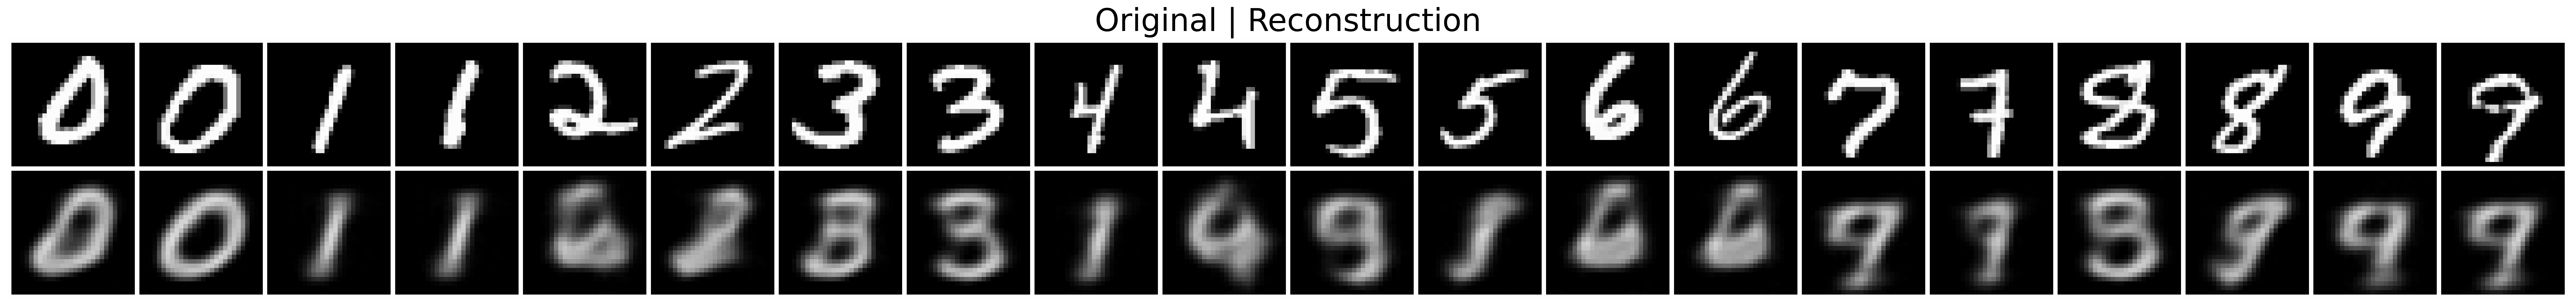

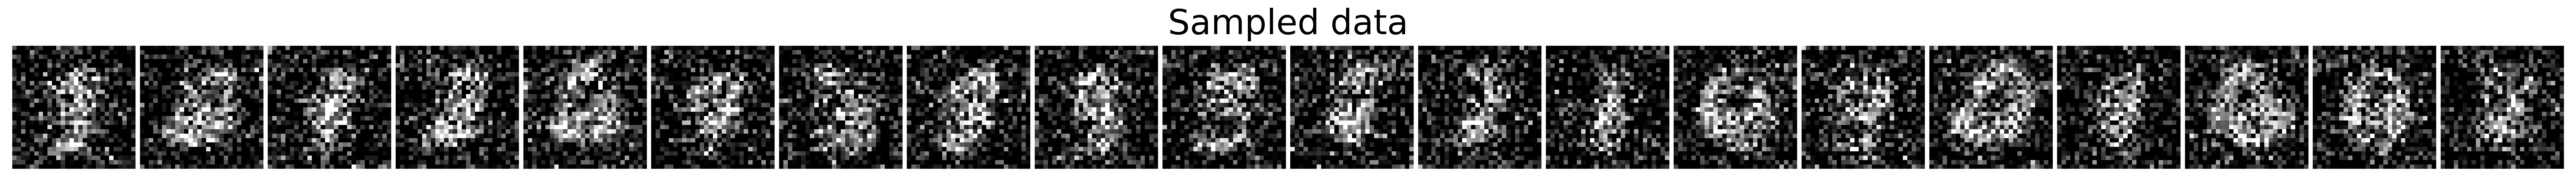

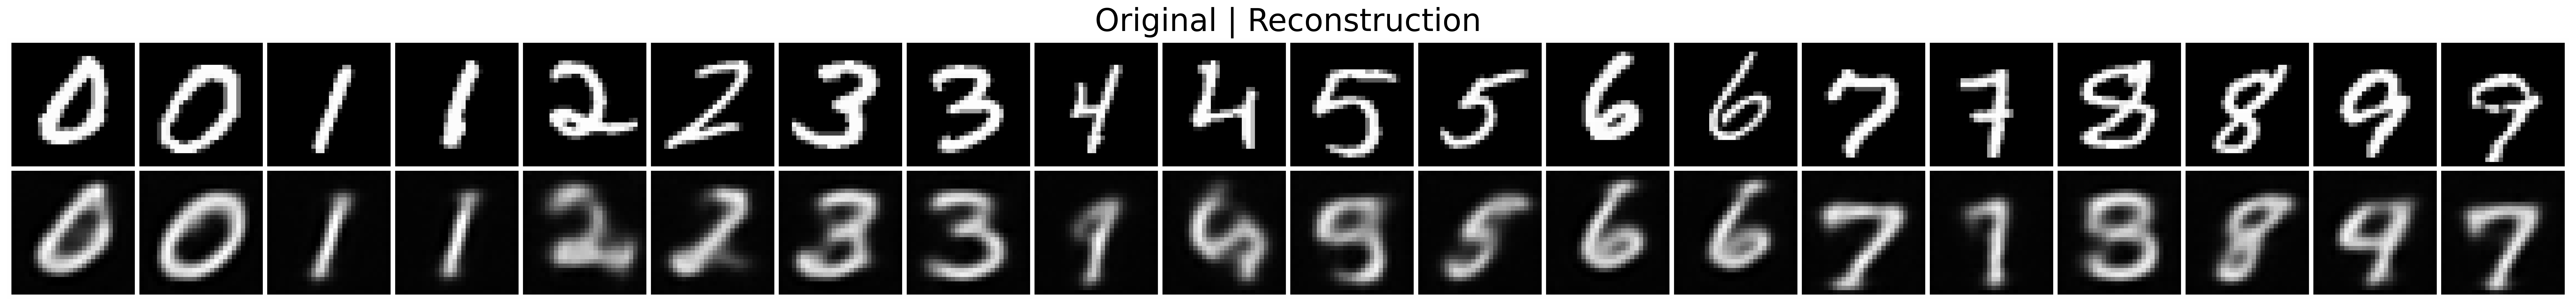

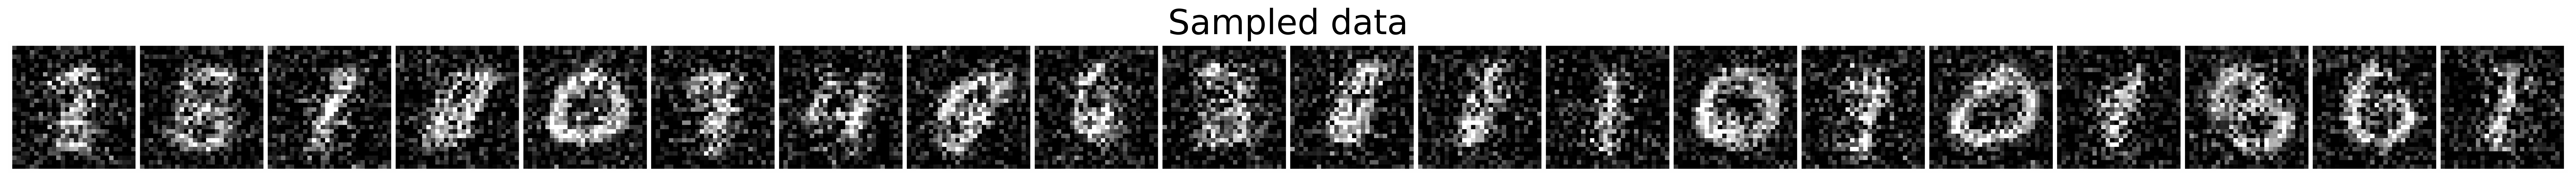

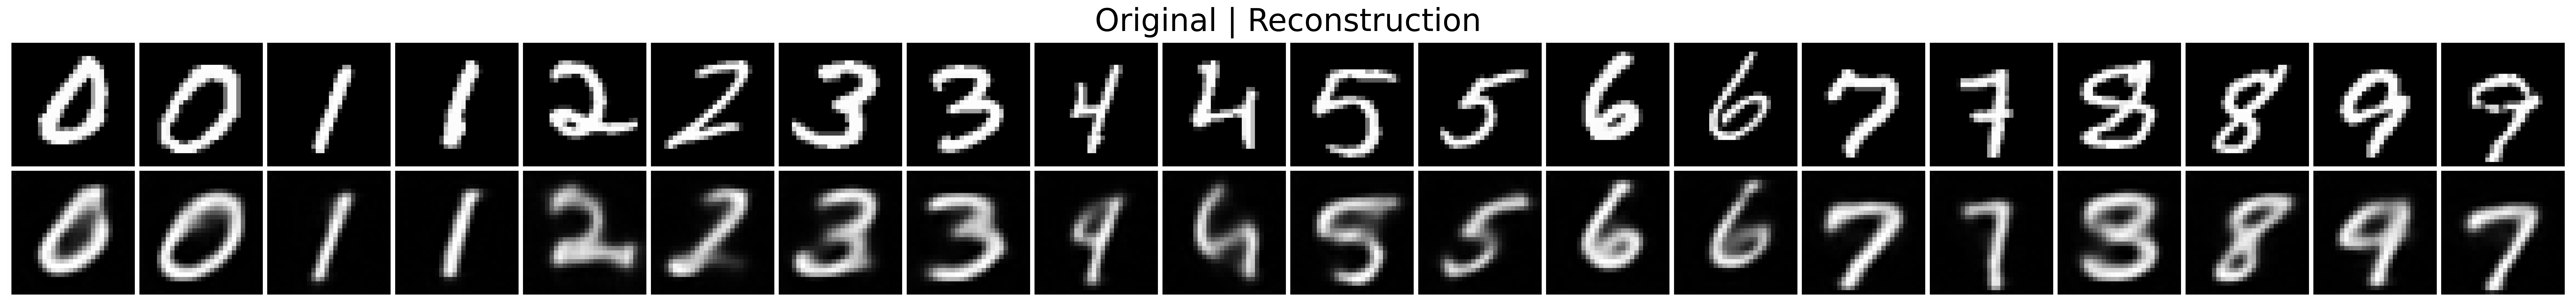

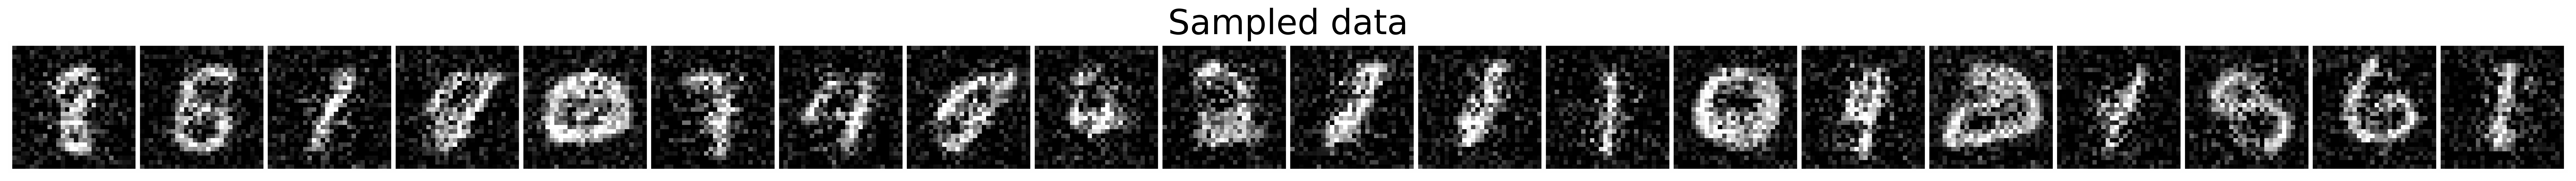

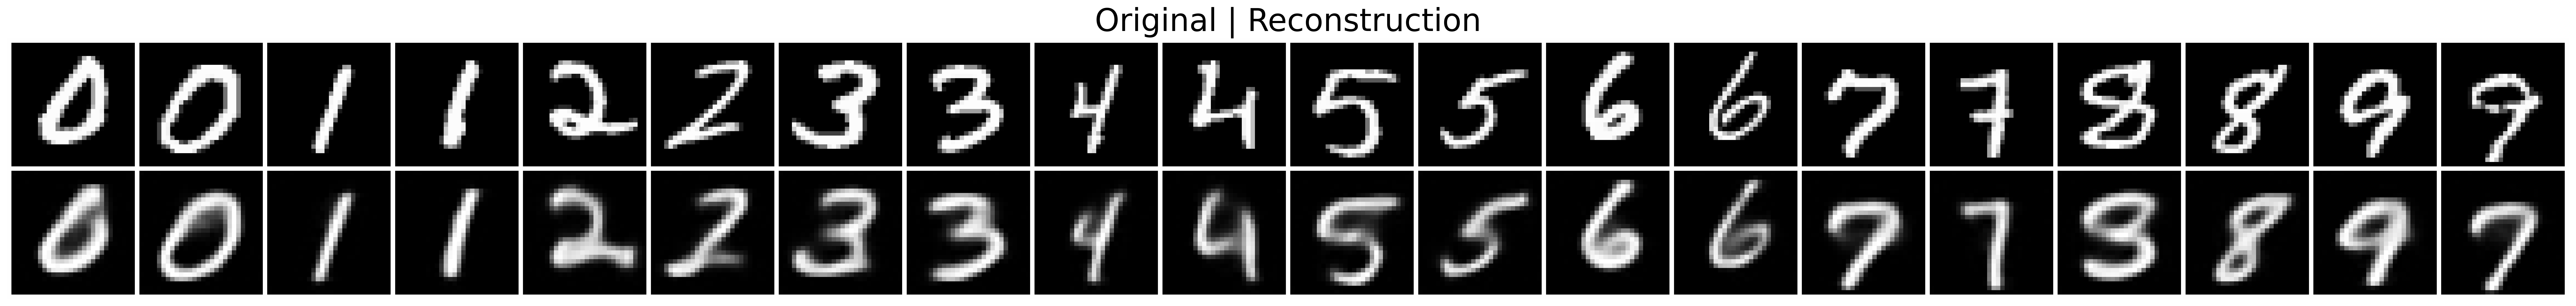

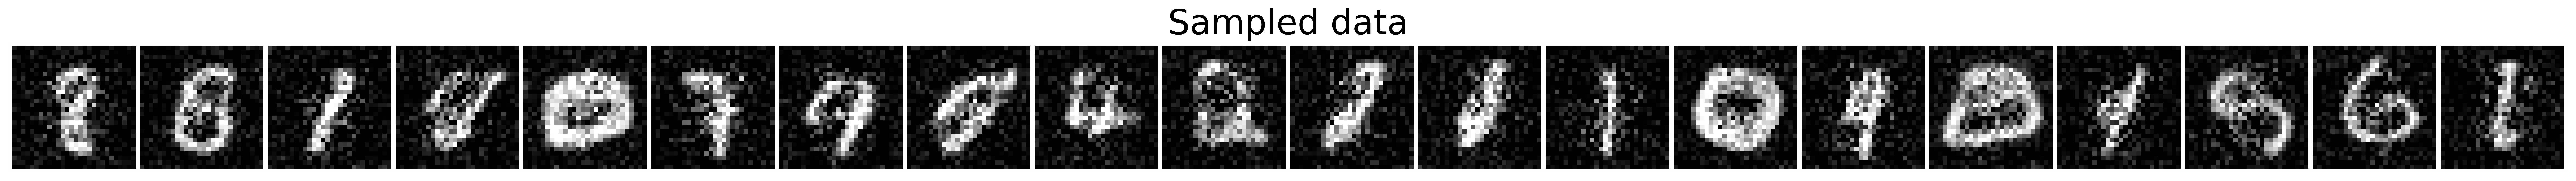

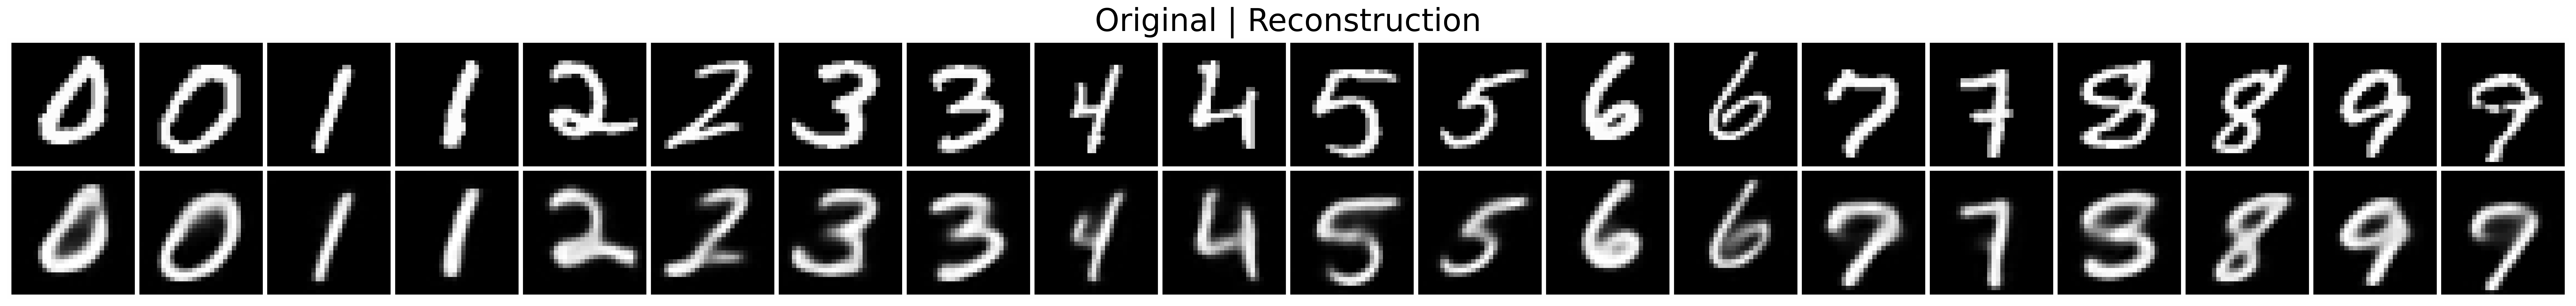

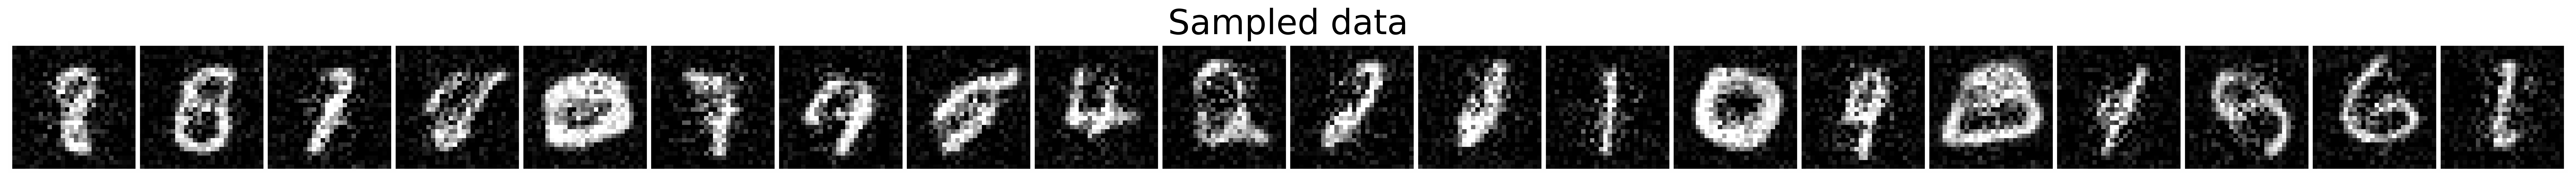

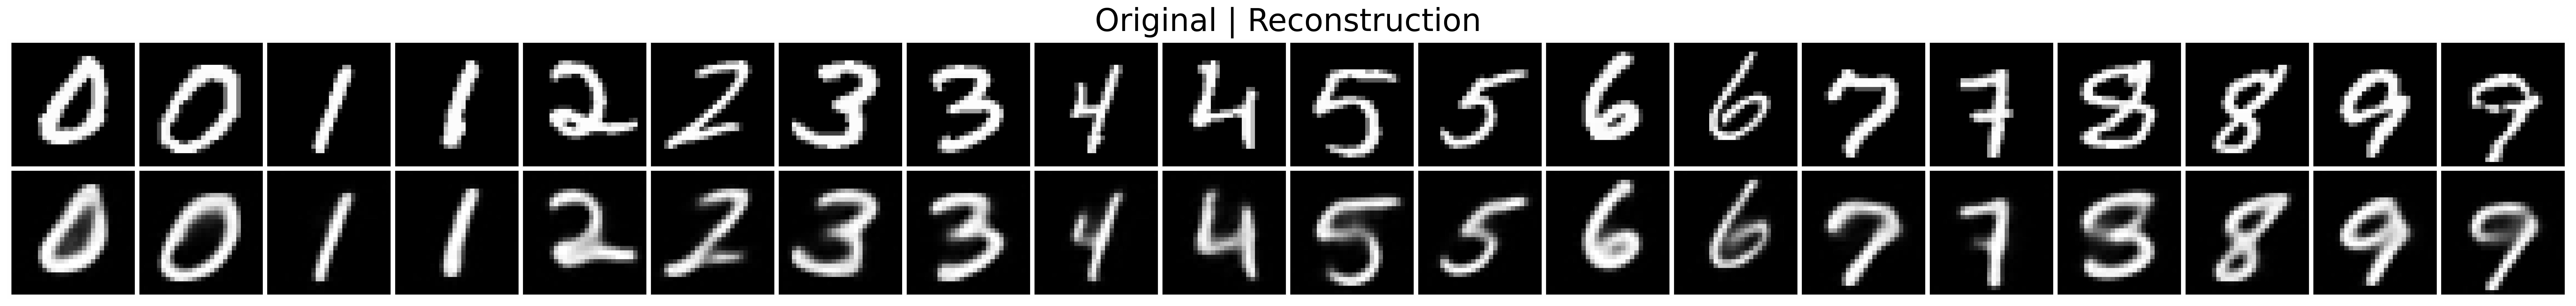

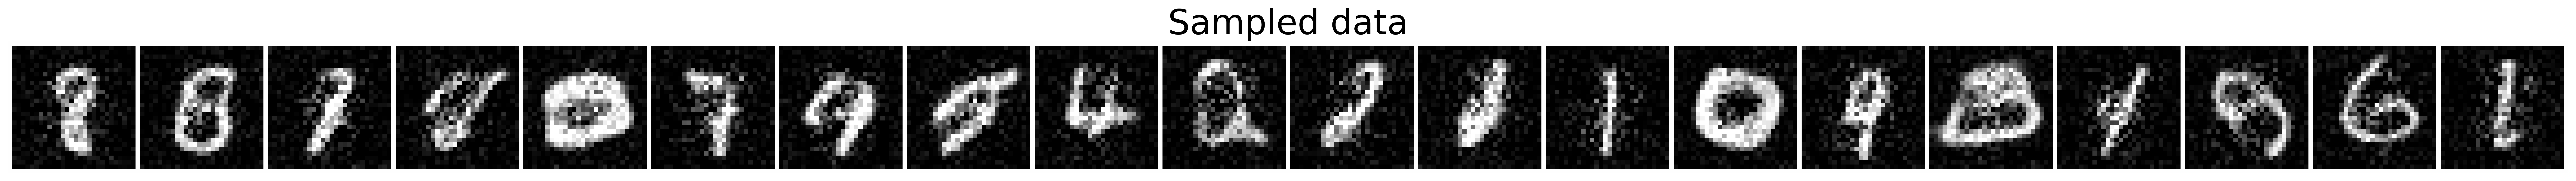

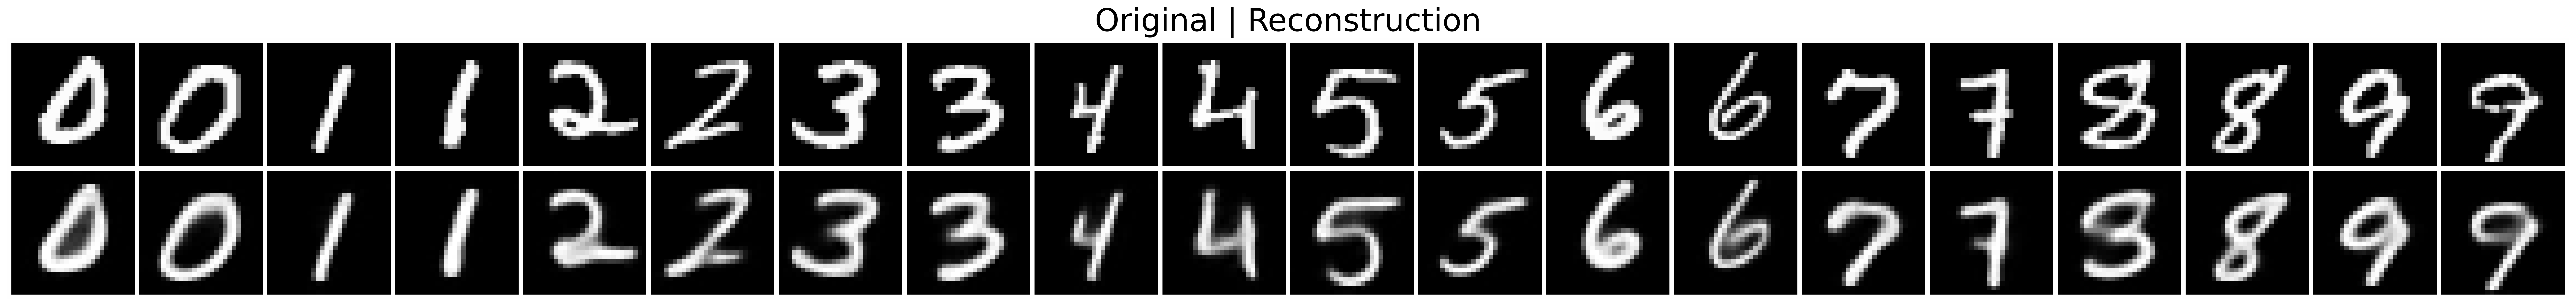

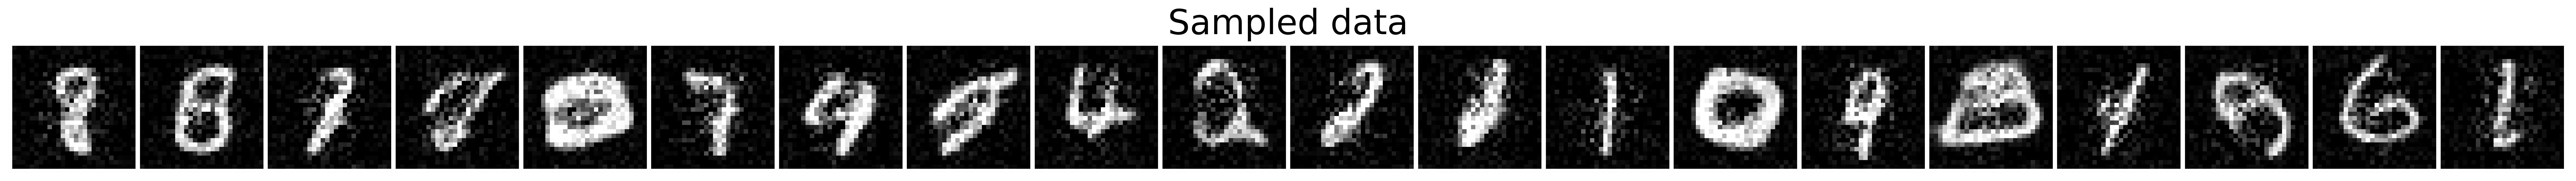

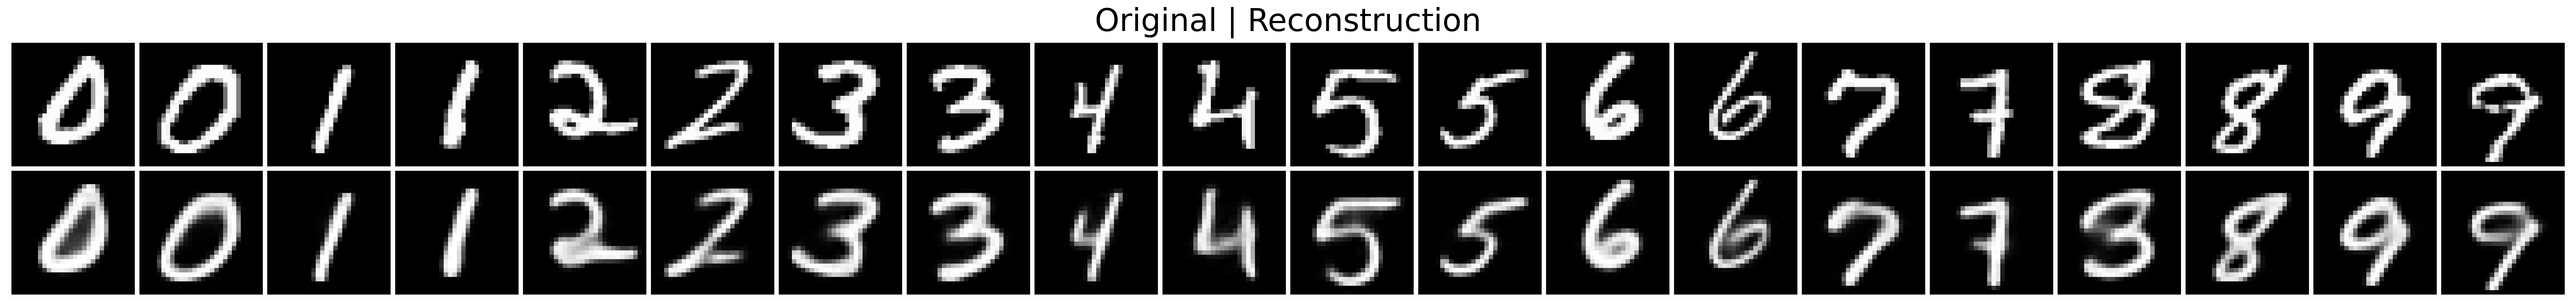

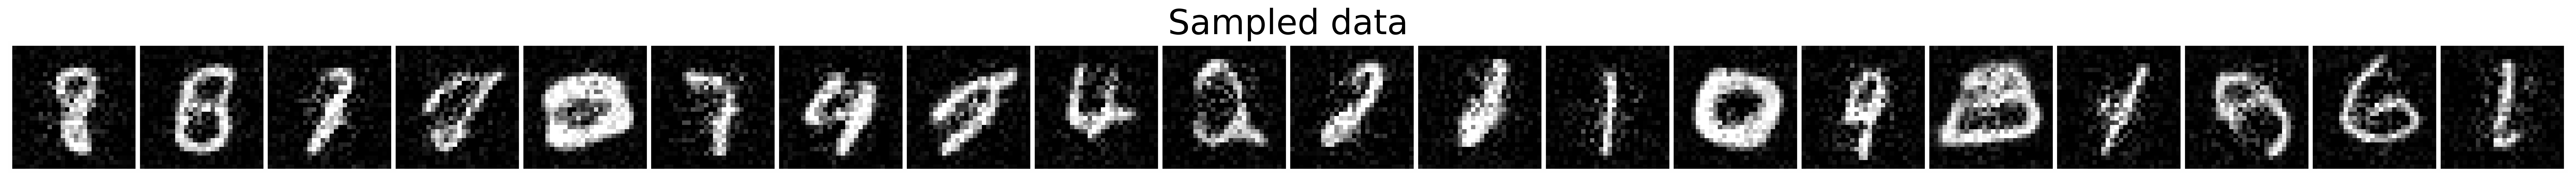

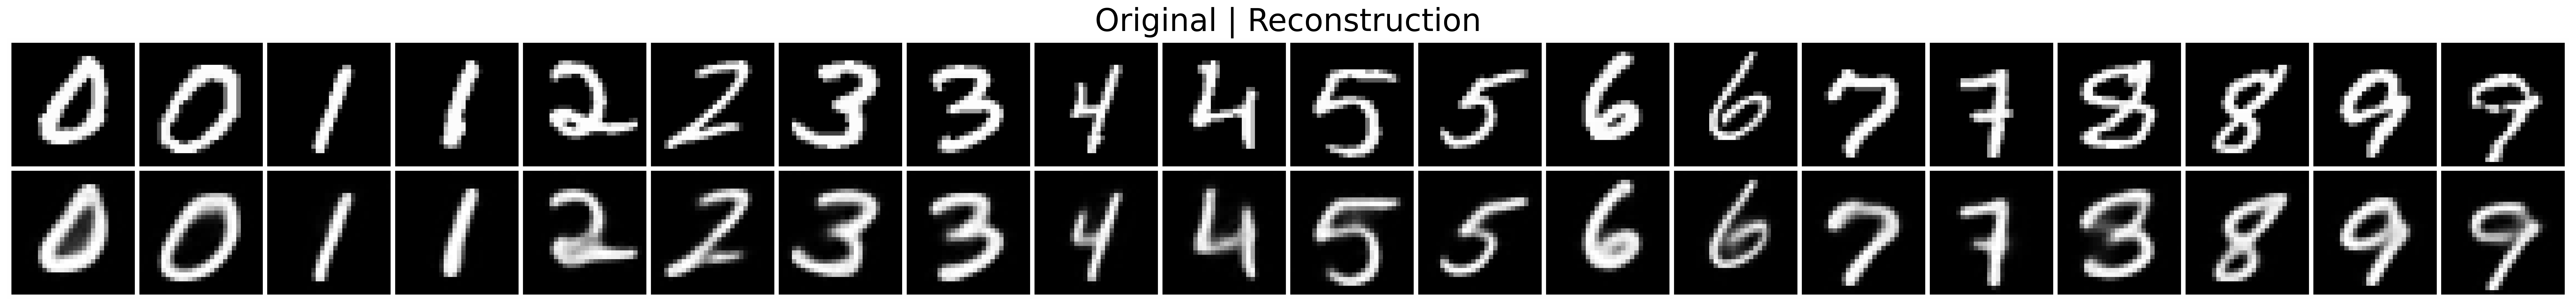

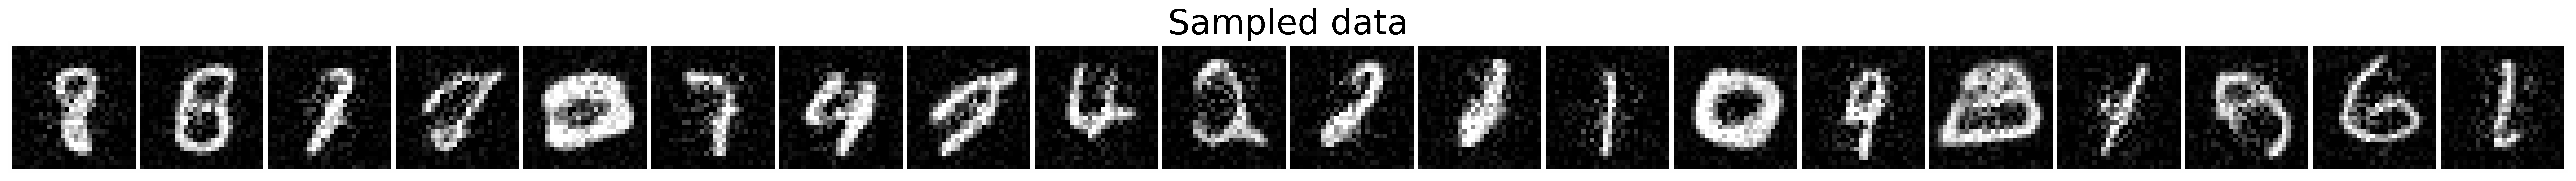

INFO:absl:Training finished.


In [8]:
best_state, final_state = train_loop(
    config,
    model,
    state,
    train_ds,
    val_ds,
    wandb_kwargs={
        'mode': 'online',
        'tags': ['test', 'VAE'], 
        'notes': (
            'Testing that code changes for SSILVAE do not mess with VAE training. '
        )
    }
);


In [9]:
-344615 / 512

-673.076171875

To try: 
1. ~~Start with small max transformations and then anneal to larger ones (only for the equivariance learning part?)~~
2. ~~Use more L2 norm - e.g. multiply by 10~~
3. ~~Use L2 norm only once - e.g. on either p or q~~
4. Think about what kind of dataset to test on for this method to make sense. Maybe we want multiple rotated versions of each digit so that there are some non-unique prototypes?
5. ~~Make the NSF more powerful... ResNet?~~
6. Add transformtion data augmentation to the flows.
7. Investigate the starred run in terms of 6 summary figs.

TODO prior exps:
1. Try make prior ~~invariant, by feeding in x_uniform.~~ equivariant?
2. Compare learning prior jointly or just after. 

In [10]:
import src.utils.input as input_utils
import src.utils.plotting as plotting_utils
from src.transformations import transform_image

In [11]:
ds = input_utils.start_input_pipeline(train_ds, 1)
xs = next(ds)['image']

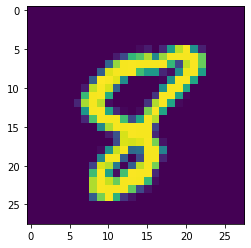

In [12]:
x = xs[0][3]
plt.imshow(plotting_utils.rescale_for_imshow(x))

In [13]:
from src.models.vae import make_vae_mll_estimator
estimate_mll = make_vae_mll_estimator(model, train=False, num_chains=10)
estimate_mll(x, rng, best_state.params)

ImportError: cannot import name 'make_vae_mll_estimator' from 'src.models.vae' (/var/home/jua23/Git/learning-invariances/src/models/vae.py)

In [ ]:
# 1 -> 524
# 3 -> -455
# 5 -> 547
# 8 -> 528
# 10 -> 551.97
# 30 -> 547.96
# 100 -> 555.53
# 300 -> 558.20
# 1000 -> 568.75

In [ ]:
if RUN_EXTRA:
    pass
else:
    raise RuntimeError("Set RUN_EXTRA to True to keep running NB.")

RuntimeError: Set RUN_EXTRA to True to keep running NB.

## Color Tests

In [ ]:
plt.imshow(plotting_utils.rescale_for_imshow(transform_image(xs[0, 2], jnp.array([.1, .1, jnp.pi/2, .1, .1, .5]))))

In [ ]:
from src.models.common import (
    Flow,
    INV_SOFTPLUS_1,
    approximate_mode,
)
from src.utils import input as input_utils
from src.transformations import transform_image
import src.utils.plotting as plotting_utils

import jax
import distrax


In [ ]:
η_rng, η_p_rng, η_pp_rng, η_recon_p_rng, η_recon_rng = random.split(rng, 5)

bounds_array = jnp.array(config.model.bounds)
offset_array = jnp.array(config.model.offset)

q_Η_given_X = Flow(
    **(config.model.Η_given_X or {}),
    event_shape=(7,),
    bounds_array=bounds_array,
    offset_array=offset_array,
)
p_Η_given_Xhat = Flow(
    **(config.model.Η_given_Xhat or {}),
    event_shape=(7,),
    bounds_array=bounds_array,
    offset_array=offset_array,
)

AttributeError: "'bounds'"

In [ ]:
val_iter = input_utils.start_input_pipeline(val_ds, config.get("prefetch_to_device", 1))
val_batch = next(val_iter)
x = val_batch['image'][0][4]

In [ ]:
q_Η_given_x = q_Η_given_X.apply({"params": final_state.params["q_Η_given_X"]}, x, train=False)

# η1 = approximate_mode(q_Η_given_x, 100, rng=η_rng)
η1 = q_Η_given_x.sample(seed=η_rng)
η1

ScopeParamShapeError: Inconsistent shapes between value and initializer for parameter "kernel" in "/cond_0/final": (128, 96), (128, 112). (https://flax.readthedocs.io/en/latest/flax.errors.html#flax.errors.ScopeParamShapeError)

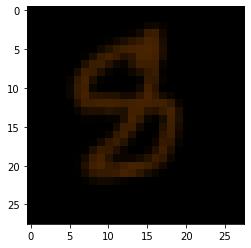

In [ ]:
xhat = transform_image(x, -η1)
plt.imshow(plotting_utils.rescale_for_imshow(xhat))

In [ ]:
p_Η_given_xhat = p_Η_given_Xhat.apply({"params": state.params["p_Η_given_Xhat"]}, x, train=False)

η2 = approximate_mode(p_Η_given_xhat, 100, rng=η_p_rng)
η2

DeviceArray([ 0.23328158,  0.14378054, -2.5265348 , -0.23094448,
              0.08132553,  0.4357713 ,  0.9801643 ], dtype=float32)

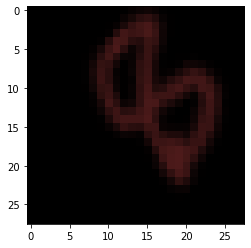

In [ ]:
xrecon = transform_image(xhat, η2)
plt.imshow(plotting_utils.rescale_for_imshow(xrecon))

In [ ]:
bounds = jnp.array(config.model.bounds)
offset = jnp.array(config.model.offset)

In [ ]:
η_rng, η_unif_rng, η_tot_rng = random.split(rng, 3)

Η_uniform = distrax.Uniform(
    low=-bounds + offset,
    high=bounds + offset,
)
η_uniform = Η_uniform.sample(seed=η_unif_rng)
η_uniform

DeviceArray([-0.22365803,  0.20020235, -2.3386316 , -0.15589088,
             -0.03869641,  0.43836045,  0.3555907 ], dtype=float32)

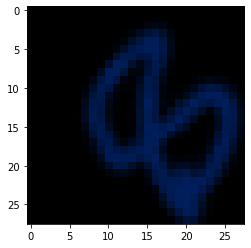

In [ ]:
x_uniform = transform_image(x, η_uniform)
plt.imshow(plotting_utils.rescale_for_imshow(x_uniform))

In [ ]:
q_Η_given_x_uniform = q_Η_given_X.apply({"params": state.params["q_Η_given_X"]}, x_uniform, train=True)
η_tot = q_Η_given_x_uniform.sample(seed=η_tot_rng)
η_tot

DeviceArray([-0.09184143, -0.22492959,  1.5648651 , -0.0368023 ,
              0.20159243,  0.07989672,  0.254591  ], dtype=float32)

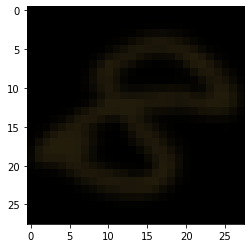

In [ ]:
xhat = transform_image(x_uniform, -η_tot)
plt.imshow(plotting_utils.rescale_for_imshow(xhat))

In [ ]:
p_Η_given_xhat = p_Η_given_Xhat.apply({"params": state.params["p_Η_given_Xhat"]}, xhat, train=True)
η_ = p_Η_given_xhat.sample(seed=η_rng)
η_

DeviceArray([-0.20699307,  0.15301141,  2.2930272 ,  0.20846437,
              0.15295033, -0.25107166,  0.30715185], dtype=float32)

In [ ]:
q_Η_given_x = q_Η_given_X.apply({"params": state.params["q_Η_given_X"]}, x, train=True)
η = q_Η_given_x.sample(seed=η_rng)
η

DeviceArray([-0.20699307,  0.15301141,  2.2930272 ,  0.20846437,
              0.15295033, -0.25107166,  0.30715185], dtype=float32)

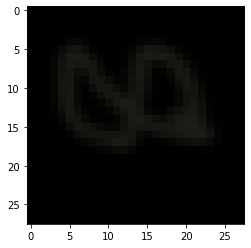

In [ ]:
xrecon = transform_image(xhat, η)
plt.imshow(plotting_utils.rescale_for_imshow(xrecon))

In [ ]:
p_X_given_xhat_and_η = distrax.Independent(
    distrax.Normal(xrecon, jax.nn.softplus(state.params['σ_']).clip(min=1e-2)), reinterpreted_batch_ndims=len(x.shape)
)

In [ ]:
bounds = jnp.array(config.model.bounds)
offset = jnp.array(config.model.offset)

η_rng, η_unif_rng, η_tot_rng = random.split(rng, 3)

Η_uniform = distrax.Uniform(
    low=-bounds + offset,
    high=bounds + offset,
)
η_uniform = Η_uniform.sample(seed=η_unif_rng)

x_uniform = transform_image(x, η_uniform)

q_Η_given_x_uniform = q_Η_given_X.apply({"params": state.params["q_Η_given_X"]}, x_uniform, train=True)
η_tot = q_Η_given_x_uniform.sample(seed=η_tot_rng)
η_tot

DeviceArray([-0.09184143, -0.22492959,  1.5648651 , -0.0368023 ,
              0.20159243,  0.07989672,  0.254591  ], dtype=float32)

In [ ]:
q_Η_given_x_uniform.sample(seed=η_tot_rng)

DeviceArray([-0.09184143, -0.22492959,  1.5648651 , -0.0368023 ,
              0.20159243,  0.07989672,  0.254591  ], dtype=float32)

In [ ]:
def loss_fn(params, rng, x):
    bounds = jnp.array(config.model.bounds)
    offset = jnp.array(config.model.offset)

    η_rng, η_unif_rng, η_tot_rng = random.split(rng, 3)

    Η_uniform = distrax.Uniform(
        low=-bounds + offset,
        high=bounds + offset,
    )
    η_uniform = Η_uniform.sample(seed=η_unif_rng)

    x_uniform = transform_image(x, η_uniform)
    
    q_Η_given_x_uniform = q_Η_given_X.apply({"params": params["q_Η_given_X"]}, x_uniform, train=True)
    η_tot = q_Η_given_x_uniform.sample(seed=η_tot_rng)

    xhat = transform_image(x_uniform, -η_tot)
    
    p_Η_given_xhat = p_Η_given_Xhat.apply({"params": params["p_Η_given_Xhat"]}, xhat, train=True)
    η_ = p_Η_given_xhat.sample(seed=η_rng)

    q_Η_given_x = q_Η_given_X.apply({"params": params["q_Η_given_X"]}, x, train=True)
    η = q_Η_given_x.sample(seed=η_rng)

    xrecon = transform_image(xhat, η)

    p_X_given_xhat_and_η = distrax.Independent(
        distrax.Normal(xrecon, jax.nn.softplus(params['σ_']).clip(min=1e-2)), reinterpreted_batch_ndims=len(x.shape)
    )
    n = 100
    ε: float = 1e-6
    β = 1
    γ = 1

    rng1, rng2 = random.split(rng, 2)

    ll = p_X_given_xhat_and_η.log_prob(x)
    # normalise ll by the number of channels
    # TODO: maybe we should normalise by the number of pixels instead?
    ll = ll / x.shape[-1]

    η_qs, q_Η_log_probs = q_Η_given_x.sample_and_log_prob(seed=rng1, sample_shape=(n,))
    q_H_entropy = -jnp.mean(q_Η_log_probs, axis=0)

    p_Η_log_probs = jax.vmap(p_Η_given_xhat.log_prob)(
        η_qs.clip(min=(1 - ε) * (-bounds) + offset, max=(1 - ε) * (bounds) + offset)
    )
    p_q_H_cross_entropy = -jnp.mean(p_Η_log_probs, axis=0)

    η_kld_ = p_q_H_cross_entropy - q_H_entropy

    def norm(η) -> float:
        return jnp.sum(η**2) / len(η)

    q_η_norm = jax.vmap(norm)(η_qs).mean()

    η_ps = p_Η_given_xhat.sample(seed=rng2, sample_shape=(n,))
    p_η_norm = jax.vmap(norm)(η_ps).mean()

    η_kld = η_kld_ + γ * (q_η_norm + p_η_norm)

    elbo = ll - β * η_kld + q_H_entropy

    return -elbo, {
        "elbo": elbo,
        "ll": ll,
        "η_kld": η_kld,
        "η_kld_": η_kld_,
        "q_η_ce": q_η_norm,
        "p_η_ce": p_η_norm,
        "entropy_term": q_H_entropy,
    }

grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
(loss, metrics), grad = grad_fn(state.params, rng, x)

print(loss)
print(metrics)

795.67175
{'elbo': DeviceArray(-795.67175, dtype=float32), 'entropy_term': DeviceArray(-1.1057593, dtype=float32), 'll': DeviceArray(-793.2932, dtype=float32), 'p_η_ce': DeviceArray(0.6800186, dtype=float32), 'q_η_ce': DeviceArray(0.59273, dtype=float32), 'η_kld': DeviceArray(1.2727481, dtype=float32), 'η_kld_': DeviceArray(-4.7683716e-07, dtype=float32)}


In [ ]:
grad

FrozenDict({
    p_Η_given_Xhat: {
        Encoder_0: {
            dense_0: {
                bias: DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                             0., 0., 0., 0.], dtype=float32),
                kernel: DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
                             [0., 0., 0., ..., 0., 0., 0.],
                             [0., 0., 0., ..., 0., 0., 0.],
                             ...,
                             [0., 0., 0., ..., 0., 0., 0.],
                             [0., 0., 0., ..., 0., 0., 0.],
                             [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
            },
            dense_1: {
                bias: DeviceArray([0., 0

In [ ]:
# calculate new params using jax tree map
new_params = jax.tree_map(lambda p, g: p - 1e-36 * g, state.params, grad)

In [ ]:
loss_fn(new_params, rng, x)

AssertionError: [Chex] Assertion assert_shape failed: Error in shape compatibility check: input 0 has shape (7,) but expected (6).

In [ ]:
q_Η_given_x_uniform = q_Η_given_X.apply({"params": new_params["q_Η_given_X"]}, x_uniform, train=True)
η_tot = q_Η_given_x_uniform.sample(seed=η_tot_rng)
η_tot

DeviceArray([-0.09184143, -0.22492959,  1.5648651 , -0.0368023 ,
              0.20159243,  0.07989672,  0.254591  ], dtype=float32)

In [ ]:
from src.transformations.color import color_transform_image, hsv_transform_image

η: [0.         0.10033467]
(r, g, b): [-1.        -1.        -0.6163977]


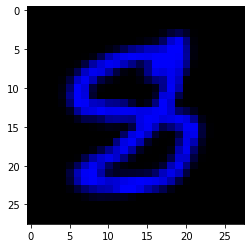

η: [-0.02250596 -0.24104635]
g: [0.02250216 0.3365341 ]
v: -0.9223950505256653
(r, g, b): [-0.960628   -0.960628   -0.92239505]


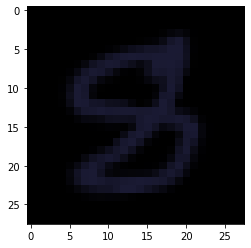

η: [ 1.1462864 -1.2562872]
g: [-0.09521863  0.10190056]
v: -1.1201064586639404
(r, g, b): [-0.8574376 -0.977544  -1.       ]


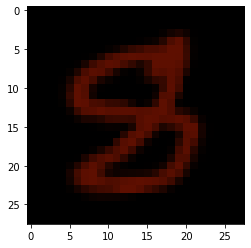

η: [  3.6124108 -10.65455  ]
g: [-0.02202768  0.03468722]
v: -1.1984946727752686
(r, g, b): [-0.8015054 -1.        -1.       ]


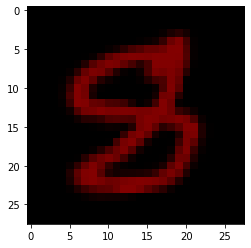

η: [11.036576   5.8347826]
g: [-0.01530593  0.0213275 ]
v: -1.2095643281936646
(r, g, b): [-0.7904357 -1.        -1.       ]


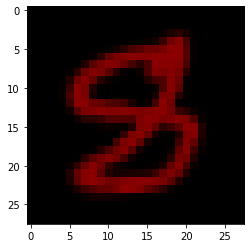

η: [-24.489529    2.7709632]
g: [-0.01162122  0.01524866]
v: -1.2146819829940796
(r, g, b): [-0.785318 -1.       -1.      ]


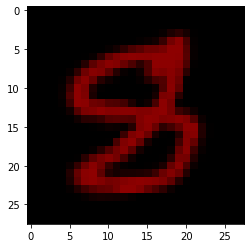

η: [-6.9094796  1.9275177]
g: [-0.00935101  0.01182157]
v: -1.217607855796814
(r, g, b): [-0.78239214 -1.         -1.        ]


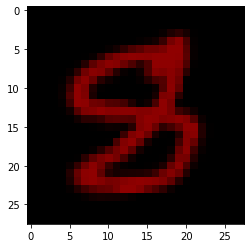

η: [-4.3023257  1.5129591]
g: [-0.00782151  0.00963429]
v: -1.2194970846176147
(r, g, b): [-0.7805029 -1.        -1.       ]


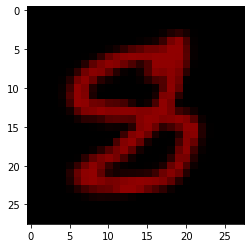

η: [-3.2295659  1.2579708]
g: [-0.00672323  0.00812149]
v: -1.2208162546157837
(r, g, b): [-0.77918375 -1.         -1.        ]


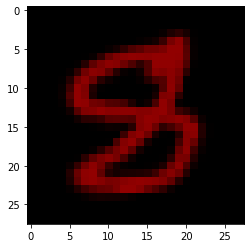

η: [-2.63446    1.0809726]
g: [-0.00589688  0.00701478]
v: -1.2217893600463867
(r, g, b): [-0.7782107 -1.        -1.       ]


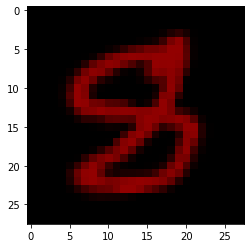

η: [-2.2508414  0.9484739]
g: [-0.00525272  0.00617084]
v: -1.2225366830825806
(r, g, b): [-0.7774633 -1.        -1.       ]


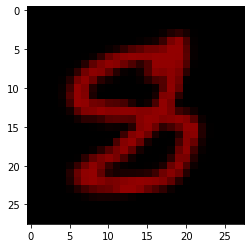

η: [-1.9799811  0.8440481]
g: [-0.00473639  0.00550652]
v: -1.2231285572052002
(r, g, b): [-0.7768715 -1.        -1.       ]


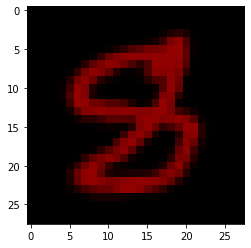

In [ ]:
def my_fn(η_, x, chan):
    new_x = hsv_transform_image(x, jnp.tanh(η_))
    means = jnp.mean(new_x, axis=(0, 1))
    mask = jnp.zeros_like(means)
    mask = mask.at[chan].set(1)
    return -jnp.sum(means * mask) + jnp.sum(means * (1 - mask)), new_x

grad_fn = jax.value_and_grad(my_fn, has_aux=True)

im = x
η_ = jnp.array([0.0, 0.1])
chan = 0

print(f'η: {jnp.tan(η_)}')
print(f'(r, g, b): {jnp.mean(im, axis=(0, 1))}')
plt.imshow(plotting_utils.rescale_for_imshow(im))
plt.show()


for i in range(101):
    (v, im_), g = grad_fn(η_, im, chan)
    η_ = η_ - 1e-0 * g
    if i % 10 == 0:
        print(f'η: {jnp.tan(η_)}')
        print(f'g: {g}')
        print(f'v: {v}')
        print(f'(r, g, b): {jnp.mean(im_, axis=(0, 1))}')
        plt.imshow(plotting_utils.rescale_for_imshow(im_))
        plt.show()

RuntimeError: Set RUN_VERIFICATION to True to run verification.

## Make rotation plots

In [ ]:
from src.utils import input as input_utils
from src.models.ssil import make_summary_plot
from src.transformations.affine import transform_image
from src.models.common import (
    Flow,
    approximate_mode,
)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde
import jax
import distrax


summary_rng = random.PRNGKey(0)

[autoreload of src.utils.training failed: Traceback (most recent call last):
  File "/var/home/jua23/.virtualenvs/inv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/var/home/jua23/.virtualenvs/inv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/var/home/jua23/.virtualenvs/inv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/var/home/jua23/.virtualenvs/inv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/var/home/jua23/.virtualenvs/inv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 303, in update_instances
    ref.__class__ = new
  File "<string>", line 4, in __setattr__
dataclasses.FrozenInstanceError: cannot assign to field '__class__'
]


In [ ]:
val_iter = input_utils.start_input_pipeline(val_ds, config.get("prefetch_to_device", 1))
val_batch = next(val_iter)
# x = val_batch['image'][0][4]
# plt.imshow(x, cmap='gray')

### Make plot

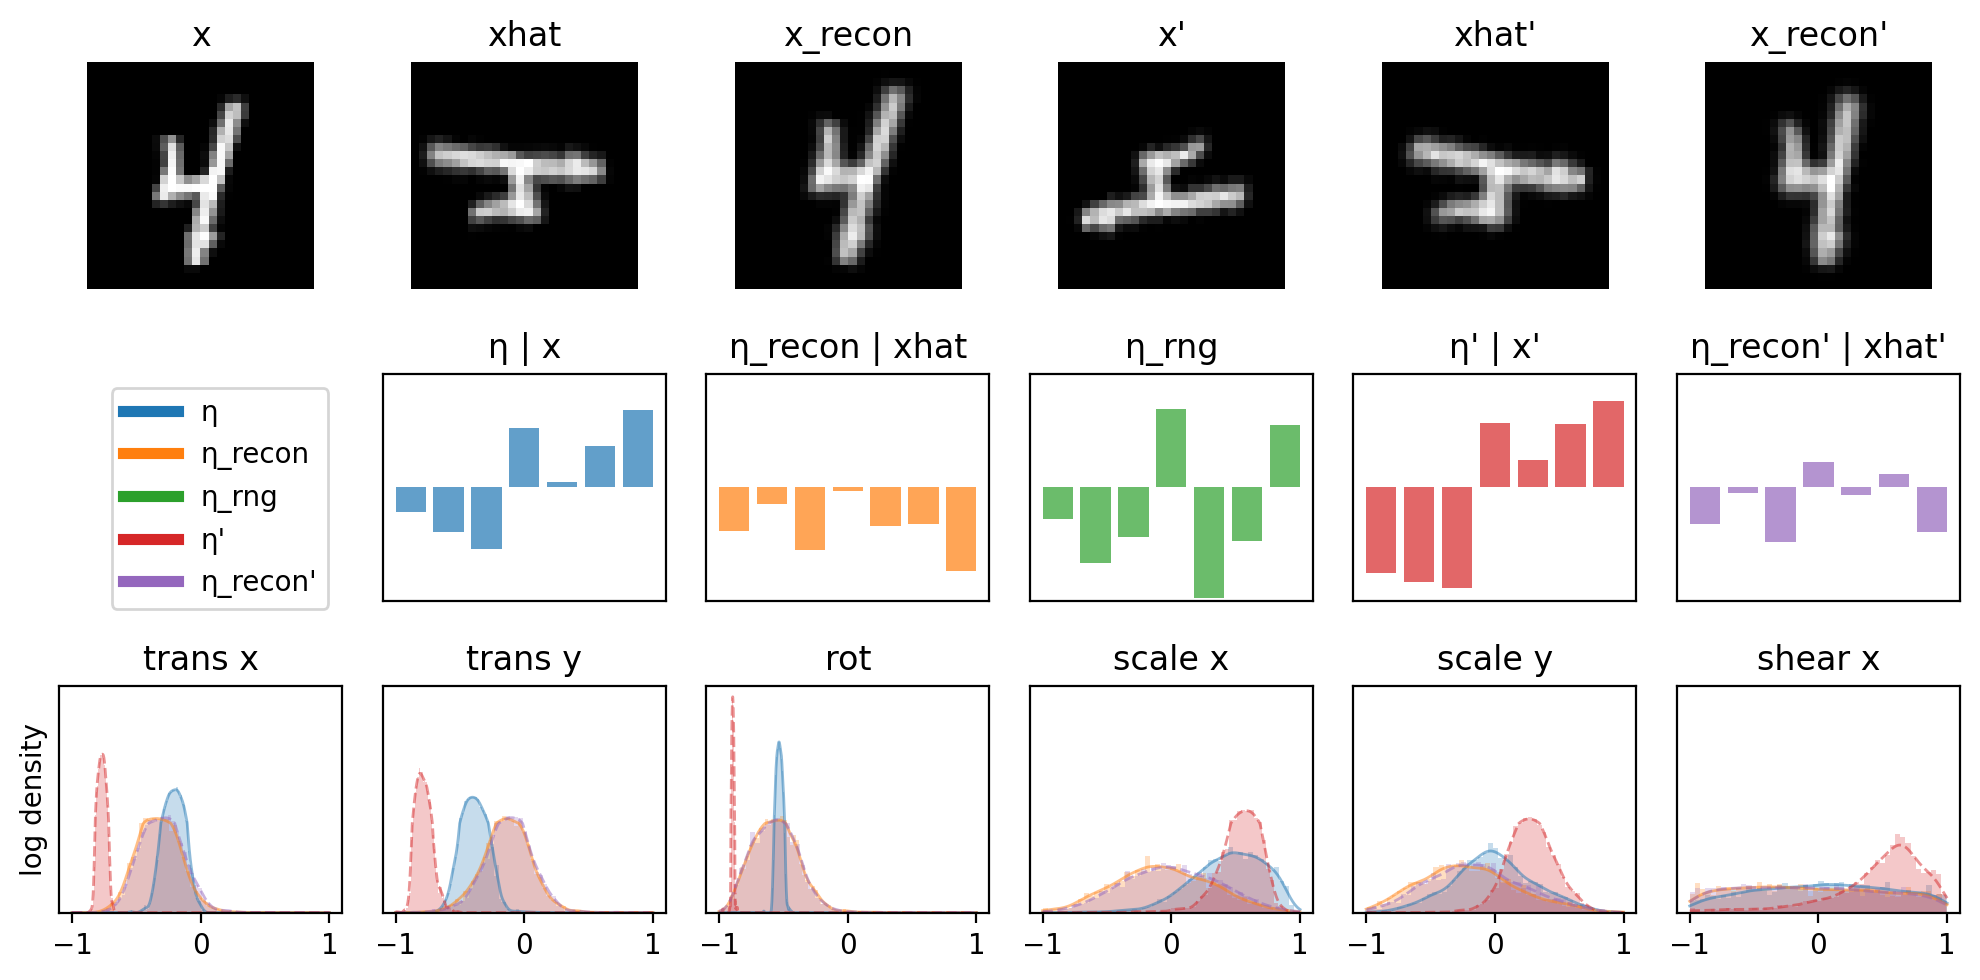

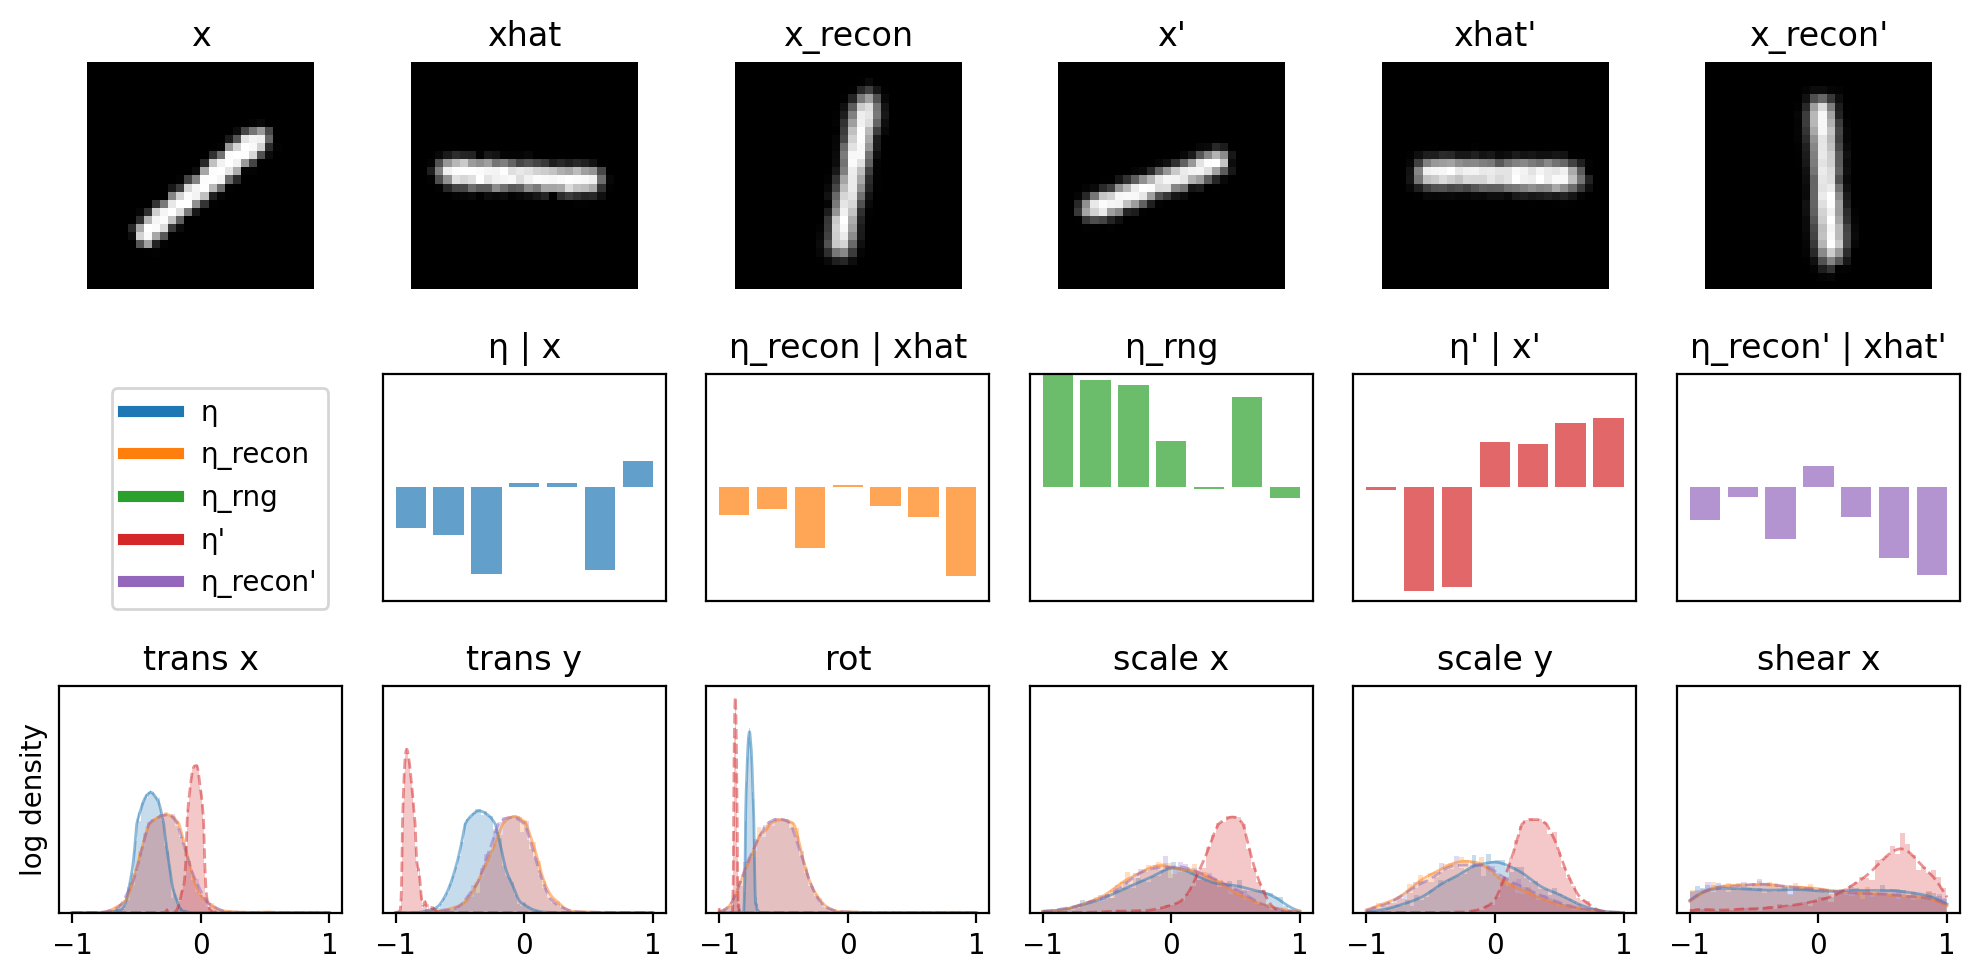

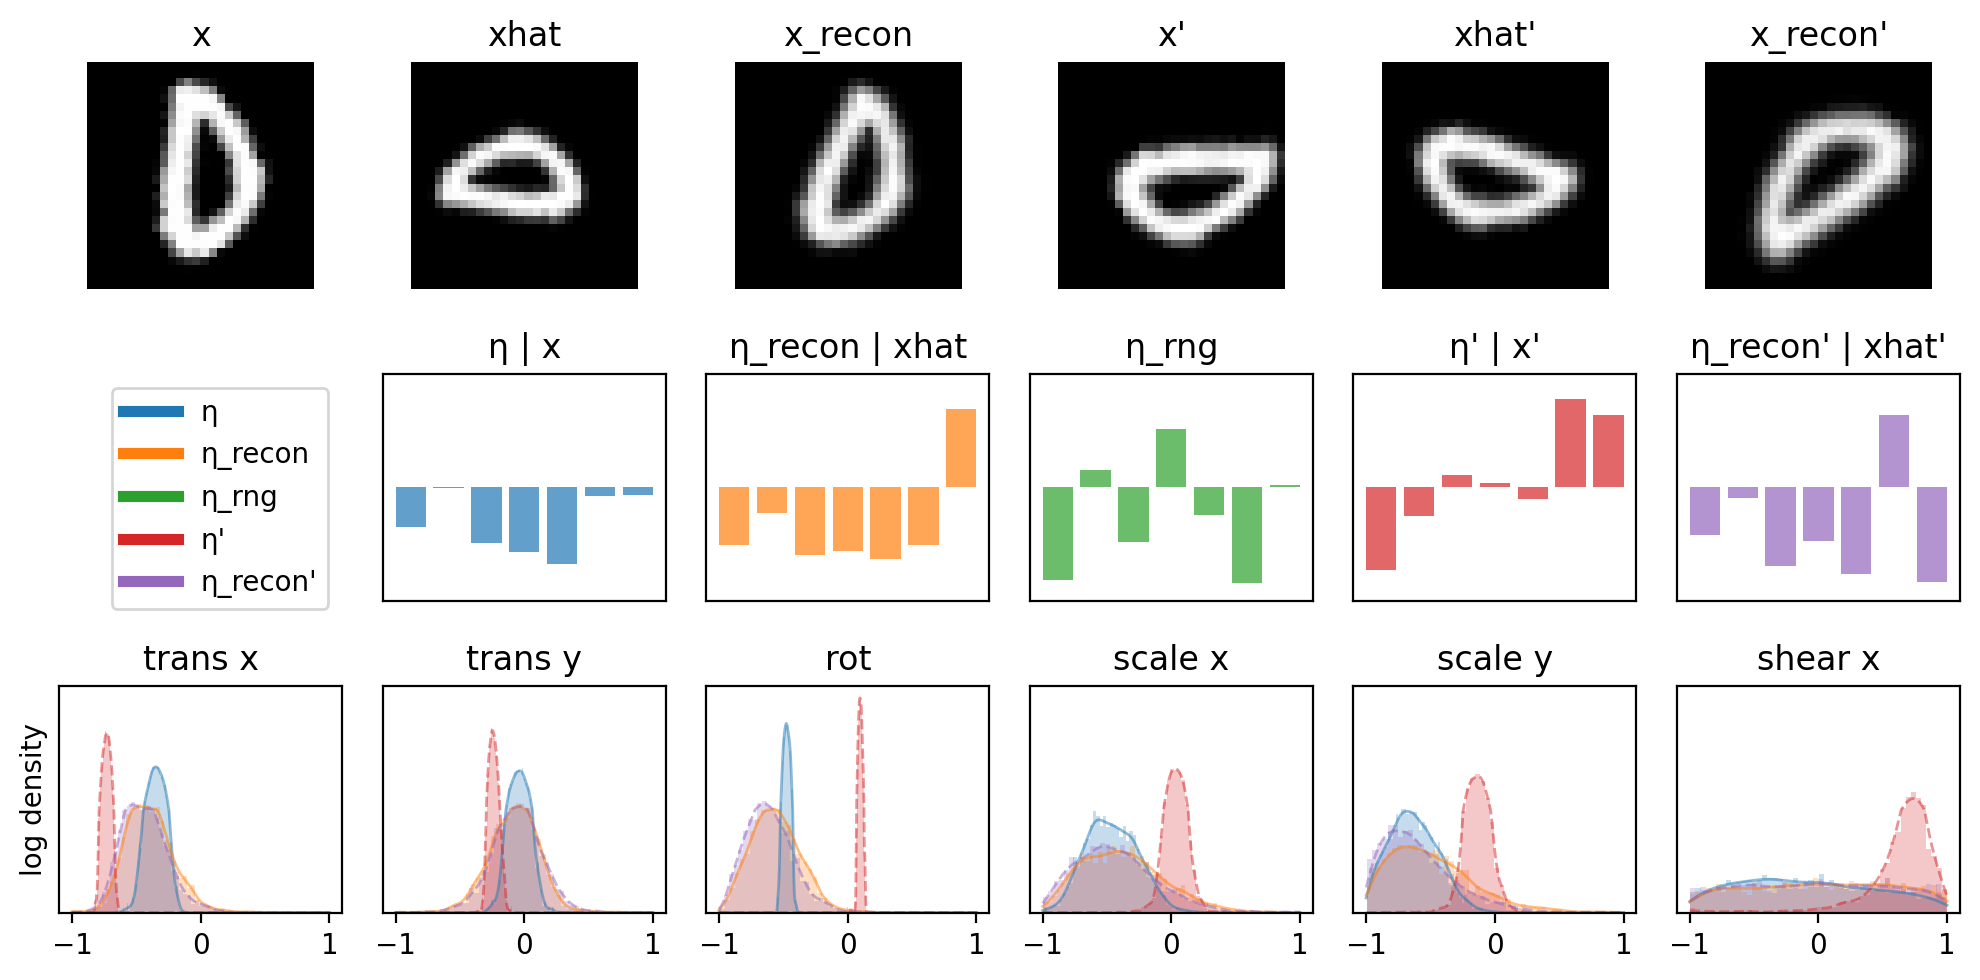

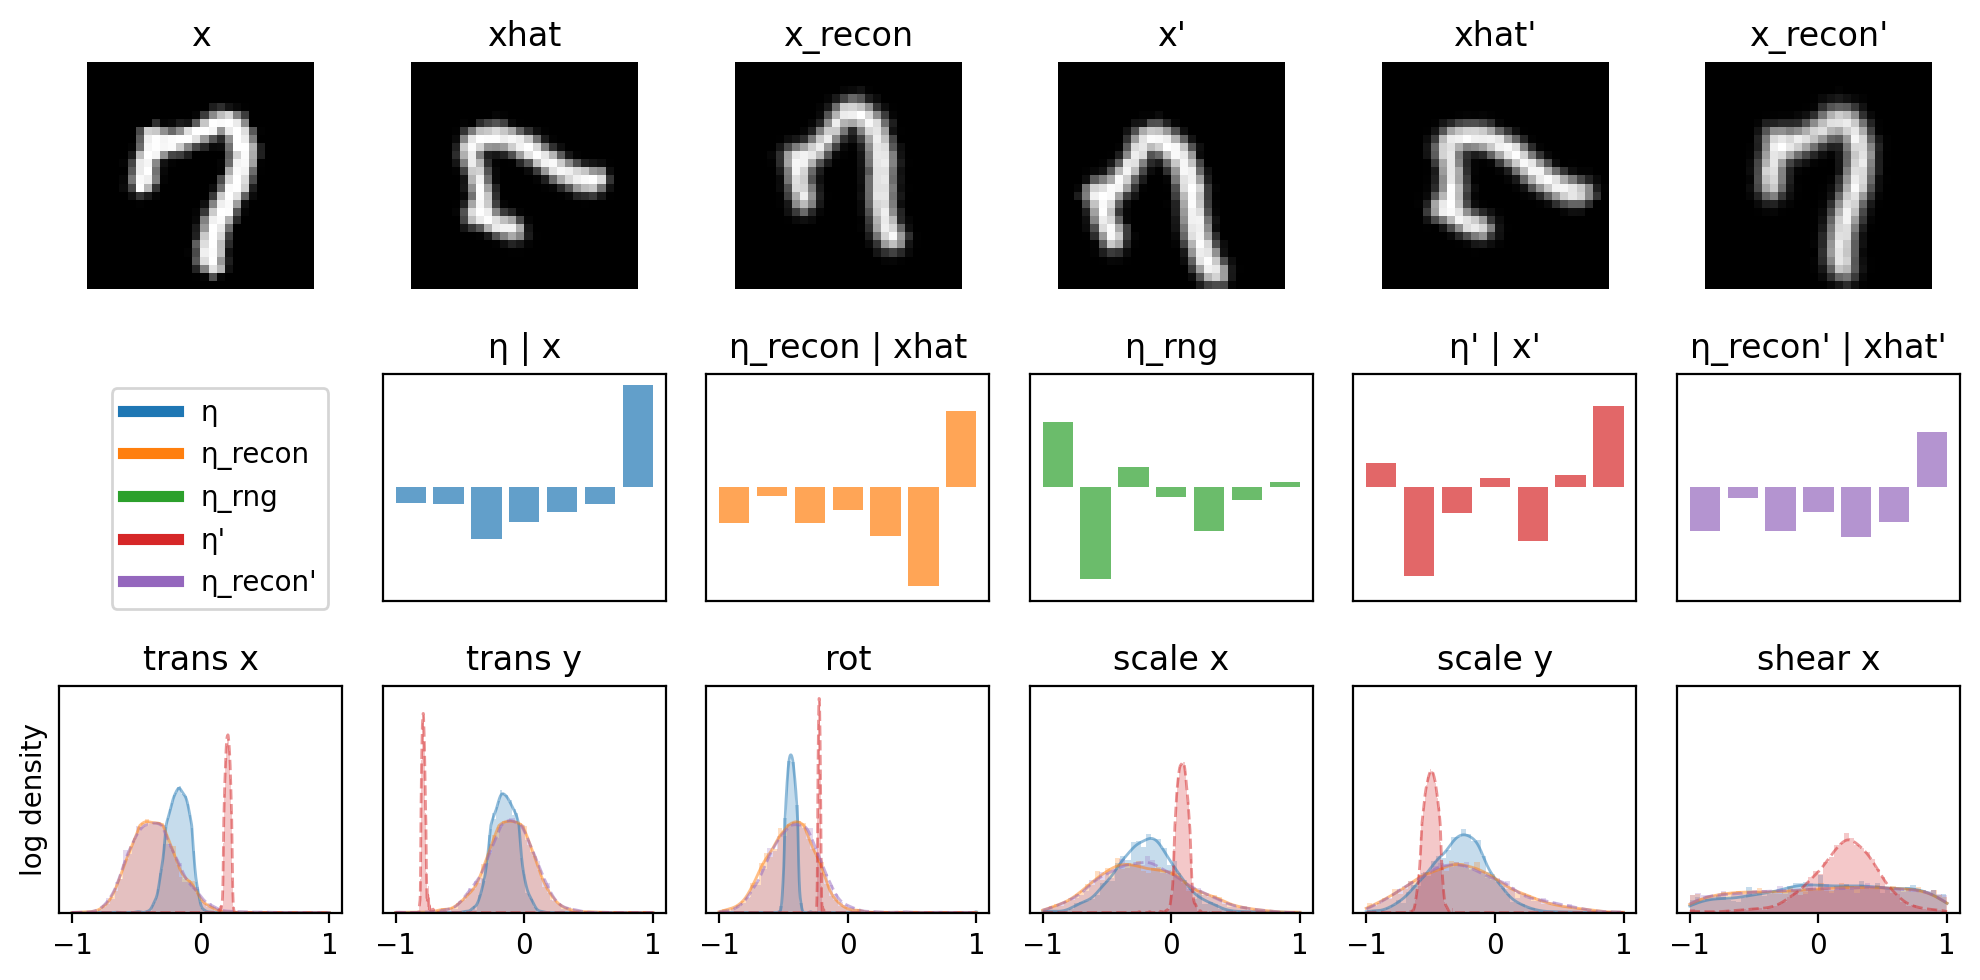

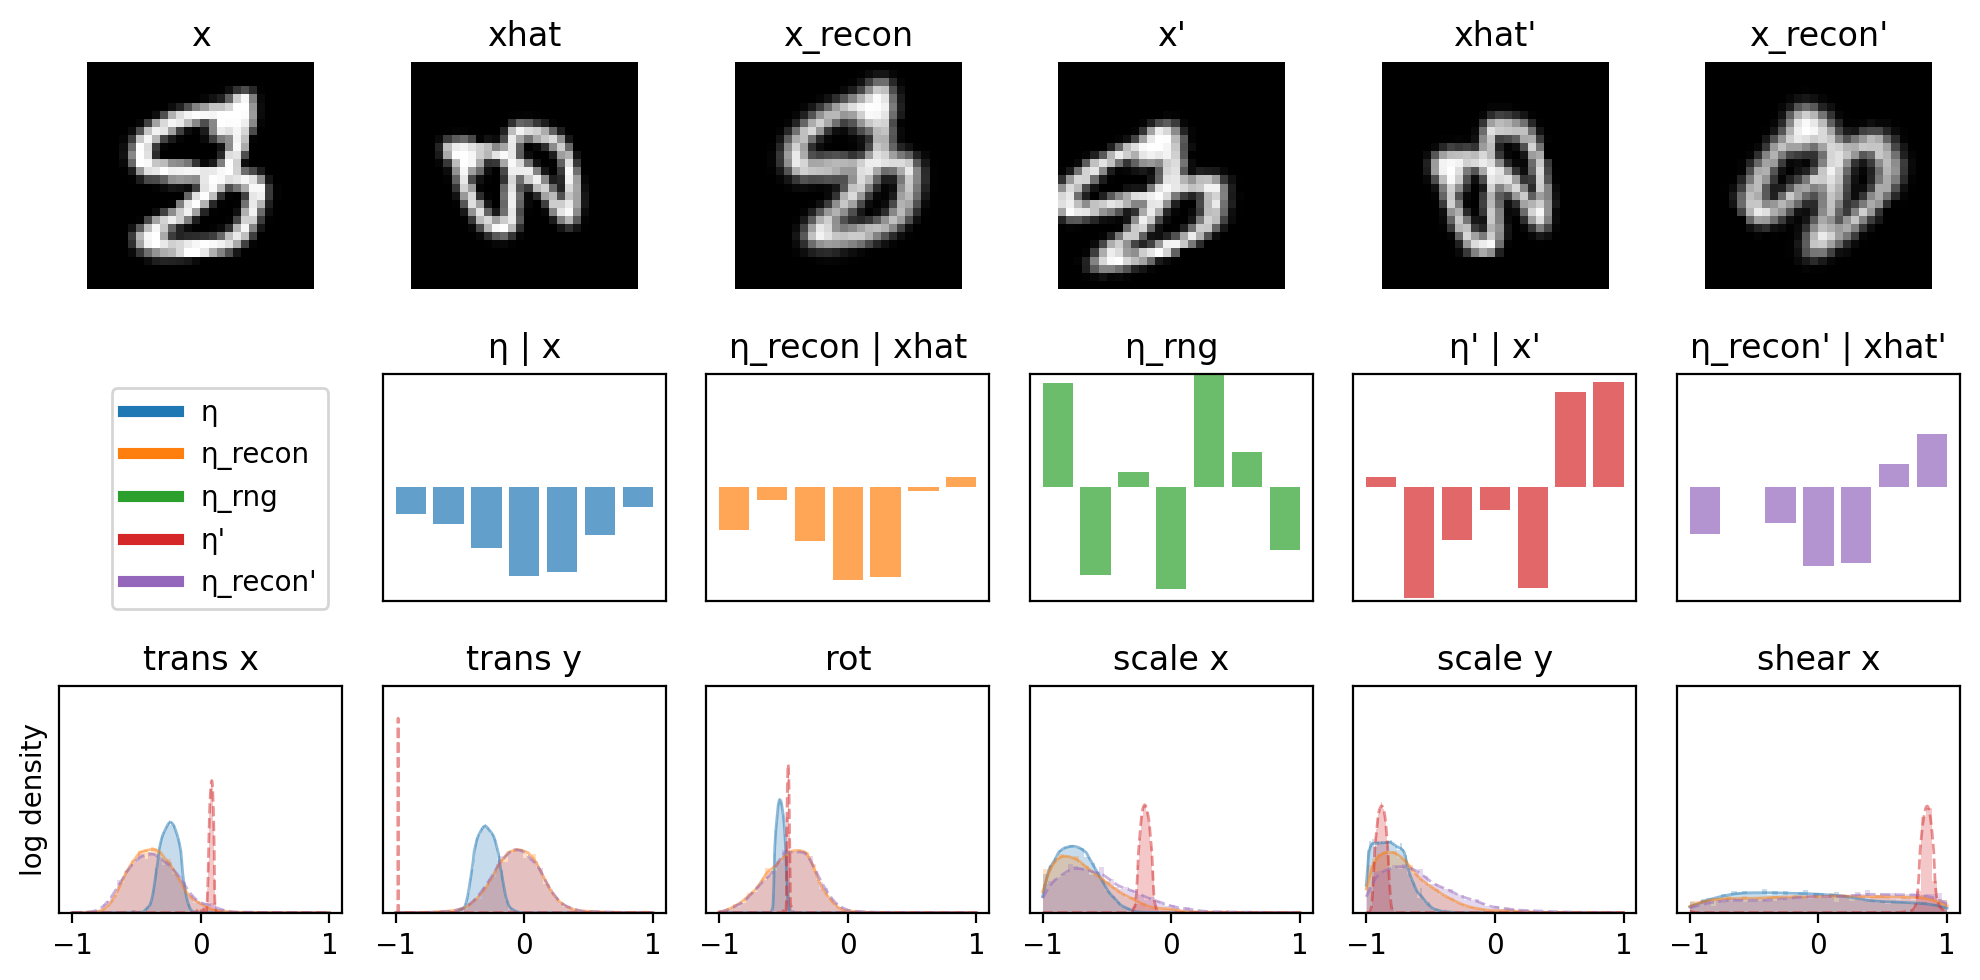

In [ ]:
for i, x in enumerate(val_batch['image'][0][:5]):
    tmp_rng, summary_rng = jax.random.split(summary_rng)
    make_summary_plot(config, final_state, x, tmp_rng)

### Investigate Distributions

In [ ]:
def make_dist_plots(dist, rng, color='C0'):
    samples, _ = dist.sample_and_log_prob(seed=rng, sample_shape=(3000,))
    samples = samples / jnp.array(config.model.bounds)
    _, num_dims = samples.shape

    fig, axs = plt.subplots(1, num_dims, figsize=(20, 4), dpi=400, sharey=True)

    for i in range(num_dims):
        axs[i].hist(samples[:, i], bins=50, density=True, color=color, alpha=0.5)
        # plot a gaussian KDE over the histogram
        x = jnp.linspace(-1, 1, 1000)
        kde = gaussian_kde(samples[:, i])
        axs[i].plot(x, kde(x), color=color)

    fig.tight_layout()
    fig.show()


In [ ]:
η, η_, p_X_given_xhat_and_η, p_Η_given_xhat, q_Η_given_x = model.apply(
    {"params": final_state.params},
    x,
    rng,
    1.0,
    train=False
)


In [ ]:
final_state.params['σ_']

ShardedDeviceArray(0.38065583, dtype=float32)

In [ ]:
p_X_given_xhat_and_η.log_prob(x)

DeviceArray(-752.90405, dtype=float32)

-673.692


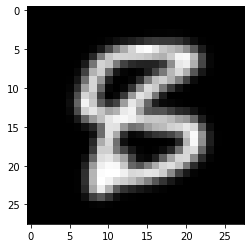

In [ ]:
x_rot = transform_image(x, jnp.array([0, 0, jnp.pi, 0, 0, 0, 0]))
plt.imshow(x_rot, cmap='gray')
print(p_X_given_xhat_and_η.log_prob(x_rot))

-786.0011


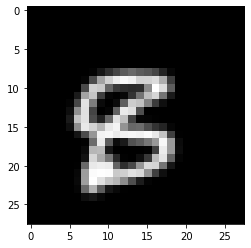

In [ ]:
x_trans = transform_image(x, jnp.array([0.25, 0.25, jnp.pi, 0.25, 0.25, 0, 0]))
plt.imshow(x_trans, cmap='gray')
print(p_X_given_xhat_and_η.log_prob(x_trans))

In [ ]:
η = approximate_mode(q_Η_given_x, 100, rng)
η

DeviceArray([-0.05048791, -0.07518937, -1.6429071 , -0.18842126,
             -0.2245992 , -0.01341782,  0.00817552], dtype=float32)

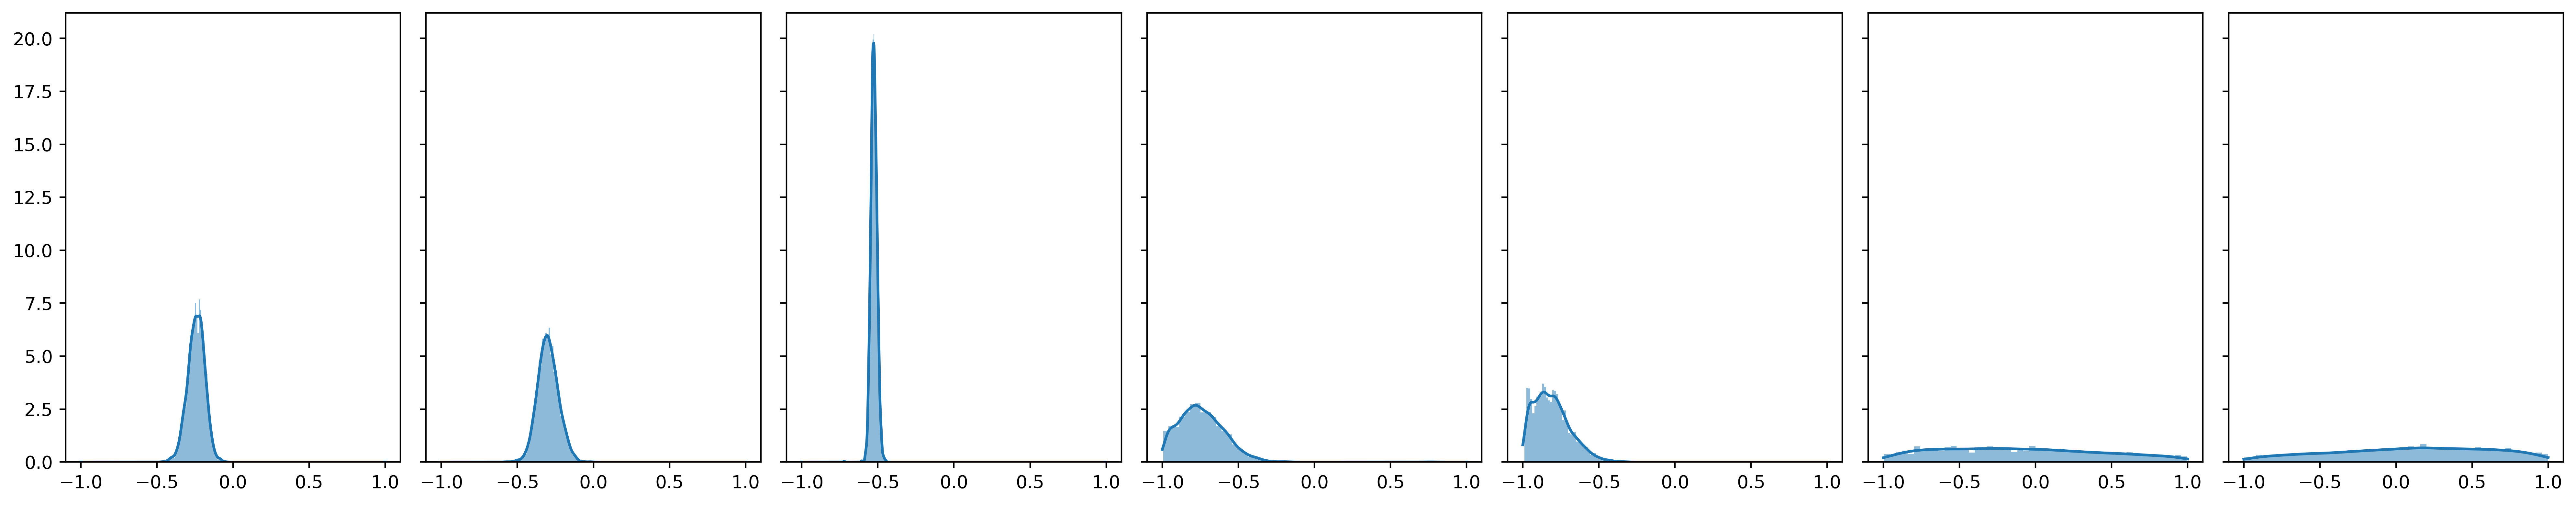

In [ ]:
make_dist_plots(q_Η_given_x, rng)

In [ ]:
q_Η_given_x.log_prob(η)

DeviceArray(18.315418, dtype=float32)

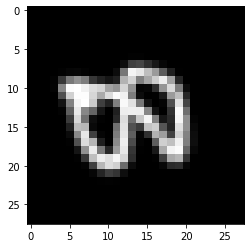

In [ ]:
x_hat = transform_image(x, -η)
plt.imshow(x_hat, cmap='gray')

In [ ]:
η2 = approximate_mode(p_Η_given_xhat, 1000, rng)
η2

DeviceArray([-0.11624698, -0.03274662, -1.7531292 , -0.24303898,
             -0.20750642,  0.02477482, -0.02615862], dtype=float32)

In [ ]:
p_Η_given_xhat.log_prob(η2)

DeviceArray(13.689987, dtype=float32)

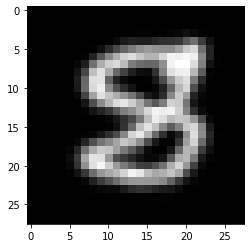

In [ ]:
x_rec = transform_image(x_hat, η2)
plt.imshow(x_rec, cmap='gray')

In [ ]:
q_Η_given_x.event_shape

JaxTransformError: Jax transforms and Flax models cannot be mixed. (https://flax.readthedocs.io/en/latest/flax.errors.html#flax.errors.JaxTransformError)